# Proyecto Final: Telecomunicaciones: identificar operadores ineficaces

### Ejercicio

El servicio de telefonía virtual CallMeMaybe está desarrollando una nueva función que brindará a los supervisores y las supervisores información sobre los operadores menos eficaces. Se considera que un operador es ineficaz si tiene una gran cantidad de llamadas entrantes perdidas (internas y externas) y un tiempo de espera prolongado para las llamadas entrantes. Además, si se supone que un operador debe realizar llamadas salientes, un número reducido de ellas también será un signo de ineficacia.

- Lleva a cabo el análisis exploratorio de datos
- Identificar operadores ineficaces
- Prueba las hipótesis estadísticas

### Descripción de los datos

Los datasets contienen información sobre el uso del servicio de telefonía virtual CallMeMaybe. Sus clientes son organizaciones que necesitan distribuir gran cantidad de llamadas entrantes entre varios operadores, o realizar llamadas salientes a través de sus operadores. Los operadores también pueden realizar llamadas internas para comunicarse entre ellos. Estas llamadas se realizan a través de la red de CallMeMaybe.

El dataset comprimido `telecom_dataset_us.csv` contiene las siguientes columnas:

- `user_id`: ID de la cuenta de cliente
- `date`: fecha en la que se recuperaron las estadísticas
- `direction`: "dirección" de llamada (`out` para saliente, `in` para entrante)
- `internal`: si la llamada fue interna (entre los operadores de un cliente o clienta)
- `operator_id`: identificador del operador
- `is_missed_call`: si fue una llamada perdida
- `calls_count`: número de llamadas
- `call_duration`: duración de la llamada (sin incluir el tiempo de espera)
- `total_call_duration`: duración de la llamada (incluido el tiempo de espera)

 

El conjunto de datos `telecom_clients_us.csv` tiene las siguientes columnas:

- `user_id`: ID de usuario/a
- `tariff_plan`: tarifa actual de la clientela
- `date_start`: fecha de registro de la clientela

## 1. Entendimiento del problema

La empresa **CallMeMaybe** ofrece un servicio de telefonía virtual utilizado por organizaciones que manejan un alto volumen de llamadas entrantes y salientes a través de operadores humanos. Con el fin de mejorar la calidad del servicio, la empresa desea identificar a los **operadores menos eficaces**, para que los supervisores puedan tomar decisiones informadas sobre capacitación, redistribución de carga o ajustes operativos.

Un operador se considera **ineficaz** cuando presenta un desempeño inferior al esperado en la gestión de llamadas, lo cual puede afectar negativamente la experiencia del cliente final y la eficiencia del servicio.

### 1.1 Criterios de ineficacia

De acuerdo con el enunciado del proyecto, un operador puede ser considerado ineficaz si cumple una o más de las siguientes condiciones:

- Tiene una **gran cantidad de llamadas entrantes perdidas**, tanto internas como externas.
- Presenta un **tiempo de espera prolongado** en las llamadas entrantes.
- En los casos donde se espera que el operador realice llamadas salientes, tiene un **número reducido de llamadas salientes**.

Estos criterios no cuentan con umbrales definidos previamente, por lo que será necesario **analizar los datos y establecer métricas y límites apropiados** basados en distribuciones estadísticas y comparaciones relativas entre operadores.

### 1.2 Objetivos del análisis

Los objetivos principales de este proyecto son:

1. Realizar un **análisis exploratorio de datos (EDA)** para comprender el comportamiento de las llamadas y de los operadores.
2. Definir métricas cuantitativas que permitan **medir la eficacia de los operadores**.
3. Identificar y clasificar a los operadores **ineficaces** según los criterios establecidos.
4. Validar los hallazgos mediante **pruebas de hipótesis estadísticas**.
5. Preparar los resultados para su **visualización en Tableau**, facilitando la toma de decisiones por parte de los supervisores.

### 1.3 Suposiciones iniciales

Para el desarrollo del análisis se consideran las siguientes suposiciones:

- No todos los operadores realizan llamadas salientes, por lo que este criterio será evaluado únicamente cuando aplique.
- Las llamadas internas y externas pueden tener comportamientos distintos, pero ambas son relevantes para medir la eficacia operativa.
- El desempeño de un operador será evaluado de forma **comparativa**, utilizando medidas relativas (percentiles, promedios, medianas) en lugar de valores absolutos arbitrarios.


## 2. Carga y revisión inicial de datos

### 2.1 Objetivo: conocer la data antes de “juzgarla”

Antes de realizar cualquier análisis o definir criterios de ineficacia, es fundamental **comprender la estructura, el contenido y la calidad de los datos disponibles**. Esta etapa tiene como propósito explorar los datasets de forma preliminar para identificar posibles limitaciones, inconsistencias o particularidades que puedan influir en el análisis posterior.

En esta fase no se extraen conclusiones sobre el desempeño de los operadores, sino que se busca:

- Entender qué información aporta cada dataset.
- Identificar las columnas relevantes para el análisis.
- Detectar posibles problemas de calidad de datos, como valores nulos, tipos incorrectos o registros incompletos.
- Obtener una primera visión general del volumen de datos y su distribución.

Este enfoque permite que las decisiones tomadas en las etapas posteriores estén **basadas en el conocimiento real de la data** y no en suposiciones previas.


### 2.1.1 Cargar ambos datasets

En este paso se cargan los dos conjuntos de datos proporcionados para el proyecto:

- **telecom_dataset_us.csv**: contiene información detallada sobre las llamadas realizadas y recibidas por los operadores.
- **telecom_clients_us.csv**: contiene información general de los clientes, incluyendo su plan tarifario y fecha de registro.

La carga correcta de ambos datasets es esencial para asegurar que la información esté disponible para el análisis exploratorio y para posibles cruces de datos en etapas posteriores.


In [65]:
## Se cargan las librerias
import os
import pandas as pd
import matplotlib.pyplot as plt

from scipy.stats import mannwhitneyu

In [54]:

# Cargar el dataset principal de telecomunicaciones
telecom_df = pd.read_csv('/datasets/telecom_dataset_us.csv')

# Cargar el dataset de clientes
clients_df = pd.read_csv('/datasets/telecom_clients_us.csv')

# Mostrar las primeras filas de cada dataset
telecom_df.head(), clients_df.head()



(   user_id                       date direction internal  operator_id  \
 0   166377  2019-08-04 00:00:00+03:00        in    False          NaN   
 1   166377  2019-08-05 00:00:00+03:00       out     True     880022.0   
 2   166377  2019-08-05 00:00:00+03:00       out     True     880020.0   
 3   166377  2019-08-05 00:00:00+03:00       out     True     880020.0   
 4   166377  2019-08-05 00:00:00+03:00       out    False     880022.0   
 
    is_missed_call  calls_count  call_duration  total_call_duration  
 0            True            2              0                    4  
 1            True            3              0                    5  
 2            True            1              0                    1  
 3           False            1             10                   18  
 4            True            3              0                   25  ,
    user_id tariff_plan  date_start
 0   166713           A  2019-08-15
 1   166901           A  2019-08-23
 2   168527           A  

### 2.1.2 Ver tamaños, columnas y tipos

Una vez cargados los datasets, se revisa su tamaño, las columnas disponibles y los tipos de datos de cada variable. Este paso permite:

- Conocer el volumen de información con el que se trabajará.
- Identificar las variables relevantes para el análisis.
- Detectar posibles inconsistencias en los tipos de datos (por ejemplo, fechas almacenadas como texto o valores numéricos con decimales innecesarios).

Esta revisión inicial es clave para anticipar transformaciones necesarias en etapas posteriores del análisis.


In [37]:
# ------------------------------------------------------
# Tamaño de los datasets
# ------------------------------------------------------
print('Tamaño del dataset de telecomunicaciones:')
print(telecom_df.shape)
print("---------------------------------------------")
print('\nTamaño del dataset de clientes:')
print(clients_df.shape)
print("---------------------------------------------")

# ------------------------------------------------------
# 
#Columnas de cada dataset
# ------------------------------------------------------
print('\nColumnas del dataset de telecomunicaciones:')
print(telecom_df.columns)
print("---------------------------------------------")
print('\nColumnas del dataset de clientes:')
print(clients_df.columns)
print("---------------------------------------------")

# ------------------------------------------------------
# Tipos de datos y valores nulos
# ------------------------------------------------------
print('\nInformación general del dataset de telecomunicaciones:')
telecom_df.info()
print("---------------------------------------------")
print('\nInformación general del dataset de clientes:')
clients_df.info()



Tamaño del dataset de telecomunicaciones:
(53902, 9)
---------------------------------------------

Tamaño del dataset de clientes:
(732, 3)
---------------------------------------------

Columnas del dataset de telecomunicaciones:
Index(['user_id', 'date', 'direction', 'internal', 'operator_id',
       'is_missed_call', 'calls_count', 'call_duration',
       'total_call_duration'],
      dtype='object')
---------------------------------------------

Columnas del dataset de clientes:
Index(['user_id', 'tariff_plan', 'date_start'], dtype='object')
---------------------------------------------

Información general del dataset de telecomunicaciones:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53902 entries, 0 to 53901
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   user_id              53902 non-null  int64  
 1   date                 53902 non-null  object 
 2   direction            53902 non-n

### 2.1.2 Tamaño, columnas y tipos de datos (Análisis)

El dataset principal de telecomunicaciones contiene **53,902 registros y 9 columnas**, mientras que el dataset de clientes cuenta con **732 registros y 3 columnas**. Esta diferencia de tamaño es esperada, ya que el primer conjunto almacena información detallada de llamadas, mientras que el segundo contiene información general de los clientes.

#### Dataset de telecomunicaciones

Las columnas disponibles en este dataset son:

- `user_id`: identificador de la cuenta del cliente.
- `date`: fecha y hora asociada a la llamada.
- `direction`: dirección de la llamada (entrante o saliente).
- `internal`: indica si la llamada es interna.
- `operator_id`: identificador del operador.
- `is_missed_call`: indica si la llamada fue perdida.
- `calls_count`: número de llamadas.
- `call_duration`: duración de la llamada sin tiempo de espera.
- `total_call_duration`: duración total de la llamada incluyendo el tiempo de espera.

En cuanto a los tipos de datos, se observa una combinación de variables numéricas, booleanas y categóricas. Algunas columnas relevantes, como `date` y `internal`, se encuentran almacenadas como tipo `object`, lo cual sugiere que podrían requerir transformaciones en etapas posteriores del análisis. Asimismo, la columna `operator_id` se encuentra almacenada como tipo `float`, lo que puede estar relacionado con la presencia de valores nulos.

#### Dataset de clientes

El dataset de clientes contiene las siguientes columnas:

- `user_id`: identificador del cliente.
- `tariff_plan`: plan tarifario del cliente.
- `date_start`: fecha de registro del cliente.

En este caso, las columnas de fecha y plan tarifario se encuentran almacenadas como tipo `object`, por lo que será necesario evaluar su conversión a formatos más adecuados para el análisis.

Este análisis preliminar permite comprender la estructura general de los datos y anticipar posibles tareas de limpieza y preparación en las siguientes etapas.


### 2.1.3 Revisión de valores nulos y duplicados

En este paso se analizan los valores nulos y los registros duplicados presentes en los datasets. Esta revisión es importante para:

- Identificar columnas con información incompleta.
- Evaluar si los valores nulos pueden afectar las métricas de desempeño de los operadores.
- Detectar posibles registros duplicados que puedan distorsionar los resultados del análisis.

El objetivo en esta etapa es **identificar** estos casos, sin aplicar aún correcciones o eliminaciones, las cuales se abordarán durante la fase de limpieza y preparación de datos.


In [38]:
# ------------------------------------------------------
# Valores nulos por columna
# ------------------------------------------------------
print('Valores nulos en el dataset de telecomunicaciones:')
print(telecom_df.isna().sum())
print("------------------------------------------------------")

print('\
nValores nulos en el dataset de clientes:')
print(clients_df.isna().sum())
print("------------------------------------------------------")

# ------------------------------------------------------
# Porcentaje de valores nulos
# ------------------------------------------------------
print('\nPorcentaje de valores nulos en telecomunicaciones:')
print((telecom_df.isna().mean() * 100).round(2))

print("------------------------------------------------------")

print('\nPorcentaje de valores nulos en clientes:')
print((clients_df.isna().mean() * 100).round(2))

print("------------------------------------------------------")

# ------------------------------------------------------
# Registros duplicados
# ------------------------------------------------------
print('\nRegistros duplicados en telecomunicaciones:')
print(telecom_df.duplicated().sum())

print("------------------------------------------------------")

print('\nRegistros duplicados en clientes:')
print(clients_df.duplicated().sum())



Valores nulos en el dataset de telecomunicaciones:
user_id                   0
date                      0
direction                 0
internal                117
operator_id            8172
is_missed_call            0
calls_count               0
call_duration             0
total_call_duration       0
dtype: int64
------------------------------------------------------
nValores nulos en el dataset de clientes:
user_id        0
tariff_plan    0
date_start     0
dtype: int64
------------------------------------------------------

Porcentaje de valores nulos en telecomunicaciones:
user_id                 0.00
date                    0.00
direction               0.00
internal                0.22
operator_id            15.16
is_missed_call          0.00
calls_count             0.00
call_duration           0.00
total_call_duration     0.00
dtype: float64
------------------------------------------------------

Porcentaje de valores nulos en clientes:
user_id        0.0
tariff_plan    0.0
date_

### 2.1.3 Valores nulos y duplicados (Análisis)

El análisis de valores nulos muestra que el **dataset de telecomunicaciones** presenta información incompleta en algunas columnas específicas, mientras que el **dataset de clientes no contiene valores nulos**.

En particular:

- La columna `operator_id` presenta **8,172 valores nulos**, lo que representa aproximadamente **15.16%** del total de los registros. Esto sugiere que existen llamadas que no están asociadas a un operador específico, lo cual será relevante al momento de evaluar el desempeño individual.
- La columna `internal` presenta **117 valores nulos** (alrededor del **0.22%**), lo que indica una afectación mínima pero que deberá ser considerada durante la limpieza de datos.
- El resto de las columnas del dataset de telecomunicaciones no presenta valores nulos.

En cuanto a los registros duplicados, se identificaron **4,900 filas duplicadas** en el dataset de telecomunicaciones, mientras que el dataset de clientes **no contiene registros duplicados**.

Estos hallazgos indican que será necesario definir una estrategia adecuada para el tratamiento de valores nulos y duplicados en el dataset de telecomunicaciones antes de realizar el análisis definitivo, asegurando así la confiabilidad de las métricas calculadas en etapas posteriores.


### 2.1.4 Primeras estadísticas descriptivas

En esta etapa se obtienen estadísticas descriptivas básicas de las variables numéricas de ambos datasets. El objetivo es contar con una primera referencia general sobre la distribución de los datos, valores típicos y posibles extremos.

Estas estadísticas permiten identificar, de manera preliminar, rangos de valores y comportamientos generales, sin realizar aún interpretaciones relacionadas con la eficacia de los operadores. Los resultados obtenidos servirán como base para el análisis exploratorio más detallado en etapas posteriores.


In [39]:
# ------------------------------------------------------
# Estadísticas descriptivas - Dataset de telecomunicaciones
# ------------------------------------------------------
print('Estadísticas descriptivas del dataset de telecomunicaciones:')
print(telecom_df.describe())

print('------------------------------------------------------')

# ------------------------------------------------------
# Estadísticas descriptivas - Dataset de clientes
# ------------------------------------------------------
print('Estadísticas descriptivas del dataset de clientes:')
print(clients_df.describe())

print('------------------------------------------------------')


Estadísticas descriptivas del dataset de telecomunicaciones:
             user_id    operator_id   calls_count  call_duration  \
count   53902.000000   45730.000000  53902.000000   53902.000000   
mean   167295.344477  916535.993002     16.451245     866.684427   
std       598.883775   21254.123136     62.917170    3731.791202   
min    166377.000000  879896.000000      1.000000       0.000000   
25%    166782.000000  900788.000000      1.000000       0.000000   
50%    167162.000000  913938.000000      4.000000      38.000000   
75%    167819.000000  937708.000000     12.000000     572.000000   
max    168606.000000  973286.000000   4817.000000  144395.000000   

       total_call_duration  
count         53902.000000  
mean           1157.133297  
std            4403.468763  
min               0.000000  
25%              47.000000  
50%             210.000000  
75%             902.000000  
max          166155.000000  
------------------------------------------------------
Estadístic

### 2.1.4 Primeras estadísticas descriptivas (Análisis)

Las estadísticas descriptivas del dataset de telecomunicaciones permiten obtener una visión general del comportamiento de las principales variables numéricas relacionadas con las llamadas.

En el caso de `calls_count`, se observa una distribución altamente asimétrica. Aunque la mediana es de 4 llamadas y el percentil 75 es de 12, existen valores máximos muy elevados, lo que indica la presencia de registros con un volumen de llamadas considerablemente superior al promedio. Este comportamiento sugiere la existencia de posibles valores atípicos que deberán analizarse con mayor detalle en la etapa de análisis exploratorio.

La variable `call_duration` presenta una mediana baja en comparación con su valor máximo, lo que indica que una gran proporción de las llamadas tiene una duración reducida, mientras que unas pocas llamadas alcanzan duraciones muy altas. Un patrón similar se observa en `total_call_duration`, donde la diferencia entre los percentiles y el valor máximo evidencia una distribución sesgada.

En cuanto al identificador de operador (`operator_id`), las estadísticas descriptivas se calculan únicamente sobre los registros no nulos, lo cual es consistente con la presencia de valores faltantes detectada en pasos anteriores.

Por su parte, el dataset de clientes muestra una distribución homogénea del identificador `user_id`, sin valores atípicos evidentes, lo cual es coherente con su función como tabla de referencia de clientes.

Estas estadísticas iniciales permiten anticipar la necesidad de un análisis más profundo de las distribuciones y de los valores extremos durante la fase de análisis exploratorio de datos (EDA).


## 3. Preparación y limpieza de datos

### 3.1 Objetivo: dejar la data lista para análisis

Luego de la revisión inicial de los datasets, es necesario realizar un proceso de **preparación y limpieza de los datos** con el fin de garantizar que la información utilizada en el análisis sea consistente, confiable y adecuada para la construcción de métricas de desempeño.

El objetivo de esta etapa es transformar los datos originales en un formato que permita:

- Eliminar o tratar adecuadamente valores incompletos o inconsistentes.
- Asegurar que las variables tengan el tipo de dato correcto.
- Separar y organizar la información según la naturaleza de las llamadas (entrantes, salientes, internas y externas).
- Crear métricas derivadas que permitan evaluar de forma objetiva la eficacia de los operadores.

Todas las decisiones tomadas durante esta etapa serán documentadas y justificadas, ya que influyen directamente en los resultados del análisis exploratorio, las pruebas estadísticas y las conclusiones finales del proyecto.


### 3.1.1 Conversión de fechas

En este paso se convierten las columnas de fecha a un formato adecuado para su análisis. Trabajar con fechas en formato correcto permite realizar operaciones temporales, ordenar registros cronológicamente y facilitar futuros análisis por periodos de tiempo.

Se realizará la conversión de:
- La columna `date` del dataset de telecomunicaciones.
- La columna `date_start` del dataset de clientes.

Esta transformación es fundamental para garantizar la consistencia temporal de los datos en las siguientes etapas del proyecto.


In [40]:
# ------------------------------------------------------
# Estado ANTES de la conversión
# ------------------------------------------------------
print('ANTES de la conversión - Tipos de datos:')
print('Telecomunicaciones:')
print(telecom_df[['date']].dtypes)

print('------------------------------------------------------')

print('Clientes:')
print(clients_df[['date_start']].dtypes)

print('------------------------------------------------------')

print('Muestras de fechas ANTES de la conversión:')
print('Telecomunicaciones:')
display(telecom_df[['date']].head())

print('------------------------------------------------------')

print('Clientes:')
display(clients_df[['date_start']].head())

print('------------------------------------------------------')


# ------------------------------------------------------
# Conversión de columnas de fecha
# ------------------------------------------------------
telecom_df['date'] = pd.to_datetime(telecom_df['date'], errors='coerce')
clients_df['date_start'] = pd.to_datetime(clients_df['date_start'], errors='coerce')

print('Conversión de fechas realizada.')
print('------------------------------------------------------')


# ------------------------------------------------------
# Estado DESPUÉS de la conversión
# ------------------------------------------------------
print('DESPUÉS de la conversión - Tipos de datos:')
print('Telecomunicaciones:')
print(telecom_df[['date']].dtypes)

print('------------------------------------------------------')

print('Clientes:')
print(clients_df[['date_start']].dtypes)

print('------------------------------------------------------')

print('Muestras de fechas DESPUÉS de la conversión:')
print('Telecomunicaciones:')
display(telecom_df[['date']].head())

print('------------------------------------------------------')

print('Clientes:')
display(clients_df[['date_start']].head())


ANTES de la conversión - Tipos de datos:
Telecomunicaciones:
date    object
dtype: object
------------------------------------------------------
Clientes:
date_start    object
dtype: object
------------------------------------------------------
Muestras de fechas ANTES de la conversión:
Telecomunicaciones:


,date
0,2019-08-04 00:00:00+03:00
1,2019-08-05 00:00:00+03:00
2,2019-08-05 00:00:00+03:00
3,2019-08-05 00:00:00+03:00
4,2019-08-05 00:00:00+03:00


------------------------------------------------------
Clientes:


,date_start
0,2019-08-15
1,2019-08-23
2,2019-10-29
3,2019-09-01
4,2019-10-16


------------------------------------------------------
Conversión de fechas realizada.
------------------------------------------------------
DESPUÉS de la conversión - Tipos de datos:
Telecomunicaciones:
date    datetime64[ns, pytz.FixedOffset(180)]
dtype: object
------------------------------------------------------
Clientes:
date_start    datetime64[ns]
dtype: object
------------------------------------------------------
Muestras de fechas DESPUÉS de la conversión:
Telecomunicaciones:


,date
0,2019-08-04 00:00:00+03:00
1,2019-08-05 00:00:00+03:00
2,2019-08-05 00:00:00+03:00
3,2019-08-05 00:00:00+03:00
4,2019-08-05 00:00:00+03:00


------------------------------------------------------
Clientes:


,date_start
0,2019-08-15
1,2019-08-23
2,2019-10-29
3,2019-09-01
4,2019-10-16


### 3.1.1 Conversión de fechas – Resultados

Antes de la conversión, las columnas `date` y `date_start` se encontraban almacenadas como tipo `object`. Esto limitaba la posibilidad de realizar operaciones temporales de forma eficiente.

Luego de aplicar la conversión:

- La columna `date` del dataset de telecomunicaciones fue convertida al tipo `datetime64` e incluye información de zona horaria (`UTC+03:00`).
- La columna `date_start` del dataset de clientes fue convertida correctamente al tipo `datetime64`, sin información de zona horaria.

La comparación visual de los valores antes y después de la conversión confirma que la información temporal se conserva correctamente, habilitando su uso para análisis cronológicos en etapas posteriores del proyecto.


### 3.1.2 Filtrado de operadores nulos o inválidos

Para evaluar la eficacia de los operadores es necesario trabajar únicamente con registros que estén asociados a un operador válido. En el análisis previo se identificó la presencia de valores nulos en la columna `operator_id`, lo que indica la existencia de llamadas que no pueden atribuirse a un operador específico.

En este paso se filtran los registros con valores nulos en `operator_id`, ya que no aportan información útil para el análisis del desempeño individual. Esta decisión permite asegurar que las métricas calculadas posteriormente representen de forma precisa la actividad de los operadores.

Los registros excluidos se documentan únicamente a nivel cuantitativo, sin eliminarlos permanentemente del dataset original.


In [41]:
# ------------------------------------------------------
# Registros antes del filtrado
# ------------------------------------------------------
print('Registros antes del filtrado:')
print(telecom_df.shape)

print('------------------------------------------------------')


# ------------------------------------------------------
# Filtrado de registros con operator_id nulo
# ------------------------------------------------------
telecom_filtered_df = telecom_df.dropna(subset=['operator_id'])

print('Filtrado de operator_id nulos realizado.')
print('------------------------------------------------------')


# ------------------------------------------------------
# Registros después del filtrado
# ------------------------------------------------------
print('Registros después del filtrado:')
print(telecom_filtered_df.shape)

print('------------------------------------------------------')


# ------------------------------------------------------
# Cantidad de registros eliminados
# ------------------------------------------------------
registros_eliminados = telecom_df.shape[0] - telecom_filtered_df.shape[0]

print('Cantidad de registros eliminados:')
print(registros_eliminados)



Registros antes del filtrado:
(53902, 9)
------------------------------------------------------
Filtrado de operator_id nulos realizado.
------------------------------------------------------
Registros después del filtrado:
(45730, 9)
------------------------------------------------------
Cantidad de registros eliminados:
8172


### 3.1.2 Filtrado de operadores nulos o inválidos – Resultados

Antes del filtrado, el dataset de telecomunicaciones contenía **53,902 registros**. Tras eliminar los registros con valores nulos en la columna `operator_id`, el conjunto de datos se redujo a **45,730 registros**, lo que implicó la exclusión de **8,172 registros**.

Esta reducción corresponde a llamadas que no están asociadas a un operador específico y, por lo tanto, no pueden ser utilizadas para evaluar el desempeño individual. El filtrado de estos registros permite garantizar que las métricas calculadas en etapas posteriores representen de manera precisa la actividad de los operadores y no introduzcan sesgos en la identificación de operadores ineficaces.

El dataset filtrado será utilizado a partir de este punto como base principal para el análisis, mientras que el dataset original se conserva sin modificaciones para referencia.


### 3.1.3 Separación de llamadas

Con el objetivo de realizar un análisis más detallado del desempeño de los operadores, las llamadas fueron clasificadas según su tipo.

En primer lugar, se separaron las llamadas **entrantes** y **salientes**, lo que permite evaluar la carga operativa asociada a la atención de clientes frente a las llamadas iniciadas por los operadores.

Adicionalmente, se distinguieron las llamadas **internas** y **externas**, diferenciando aquellas realizadas dentro de la organización de las que implican interacción directa con clientes. Esta segmentación es clave para calcular métricas específicas de atención al cliente y evitar distorsiones en el análisis de eficiencia.

A partir de este punto, el análisis podrá enfocarse exclusivamente en los tipos de llamadas relevantes para la evaluación del rendimiento operativo.


In [42]:
print("="*60)
print("📞 3.1.3 SEPARACIÓN DE LLAMADAS")
print("="*60)

# Copia del dataset ya filtrado
calls_df = telecom_filtered_df.copy()

# 3.1.3.1 Llamadas entrantes vs salientes
incoming_calls = calls_df[calls_df['direction'] == 'in']
outgoing_calls = calls_df[calls_df['direction'] == 'out']

print("\n📥 Llamadas entrantes:")
print(incoming_calls.shape)

print("\n📤 Llamadas salientes:")
print(outgoing_calls.shape)

print("-"*60)

# 3.1.3.2 Llamadas internas vs externas
internal_calls = calls_df[calls_df['internal'] == True]
external_calls = calls_df[calls_df['internal'] == False]

print("\n🏢 Llamadas internas:")
print(internal_calls.shape)

print("\n🌍 Llamadas externas:")
print(external_calls.shape)



📞 3.1.3 SEPARACIÓN DE LLAMADAS

📥 Llamadas entrantes:
(14013, 9)

📤 Llamadas salientes:
(31717, 9)
------------------------------------------------------------

🏢 Llamadas internas:
(5809, 9)

🌍 Llamadas externas:
(39861, 9)


### 3.1.3 Separación de llamadas (Análisis)

Tras filtrar los registros con `operator_id` válido, se realizó la segmentación de las llamadas con base en su dirección y tipo.

📥 **Llamadas entrantes:** 14.013 registros  
📤 **Llamadas salientes:** 31.717 registros  

Esto indica que la mayor parte de la actividad corresponde a llamadas salientes, lo cual es consistente con un entorno de contact center donde los operadores realizan campañas activas o seguimientos a clientes.

---

🏢 **Llamadas internas:** 5.809 registros  
🌍 **Llamadas externas:** 39.861 registros  

La gran mayoría de las llamadas son externas, lo que sugiere que el foco operativo del sistema está en la interacción con clientes y no en comunicaciones internas entre operadores.

---

Esta separación permitirá, en etapas posteriores, analizar métricas operativas como tiempos de espera, llamadas perdidas y desempeño por operador de manera más precisa.


### 3.1.3.1 Validación de valores extremos

Se realizó una validación de valores extremos sobre las principales variables relacionadas con la duración de las llamadas y el tiempo de espera.

El análisis de las estadísticas descriptivas muestra la presencia de valores máximos considerablemente altos, especialmente en la variable `waiting_time`. Para evaluar estos casos, se utilizó el percentil 99 como referencia, lo que permitió identificar registros con tiempos de espera excepcionalmente elevados.

La presencia de estos valores extremos no implica necesariamente errores en los datos, ya que pueden corresponder a situaciones reales como sobrecarga del sistema o fallos operativos. Por esta razón, los registros no fueron eliminados en esta etapa y se conservaron para el análisis posterior, considerando que son relevantes para la identificación de operadores ineficaces.


### 3.1.4 Creación de métricas útiles
🎯 Objetivo

Construir métricas operativas que permitan evaluar el desempeño de los operadores, la experiencia del cliente y la eficiencia del sistema de llamadas, a partir de los datos ya filtrados y segmentados.

Estas métricas serán la base para el análisis exploratorio, comparaciones y visualizaciones posteriores.

### 3.1.4.1 Tiempo de espera

El tiempo de espera se calculó como la diferencia entre la duración total de la llamada y la duración efectiva de la conversación:

waiting_time = total_call_duration - call_duration

Este indicador representa el tiempo que una llamada permanece en cola antes de ser atendida por un operador.

Como parte del control de calidad de los datos, se verificó la existencia de valores negativos en el tiempo de espera, ya que estos podrían indicar inconsistencias en los registros.

Las estadísticas descriptivas del tiempo de espera permiten analizar su distribución general, identificar valores atípicos y detectar posibles comportamientos ineficientes por parte de los operadores.

Esta métrica será utilizada en los siguientes pasos del análisis para evaluar el desempeño operativo y apoyar la identificación de operadores ineficaces.


In [43]:


calls_df['waiting_time'] = (
    calls_df['total_call_duration'] - calls_df['call_duration']
)

print("Tiempo de espera calculado correctamente.")
print("------------------------------------------------------")

negative_waiting = (calls_df['waiting_time'] < 0).sum()

print("Cantidad de tiempos de espera negativos:")
print(negative_waiting)
print("------------------------------------------------------")

print("Estadísticas descriptivas del tiempo de espera:")
print(calls_df['waiting_time'].describe())
print("------------------------------------------------------")

print("Muestra de tiempos de espera:")
print(
    calls_df[['call_duration', 'total_call_duration', 'waiting_time']].head()
)


Tiempo de espera calculado correctamente.
------------------------------------------------------
Cantidad de tiempos de espera negativos:
0
------------------------------------------------------
Estadísticas descriptivas del tiempo de espera:
count    45730.000000
mean       312.376667
std       1174.185593
min          0.000000
25%         19.000000
50%         60.000000
75%        220.000000
max      46474.000000
Name: waiting_time, dtype: float64
------------------------------------------------------
Muestra de tiempos de espera:
   call_duration  total_call_duration  waiting_time
1              0                    5             5
2              0                    1             1
3             10                   18             8
4              0                   25            25
5              3                   29            26


### Resultados del cálculo del tiempo de espera

El cálculo del tiempo de espera se realizó correctamente para todos los registros del dataset filtrado.

No se identificaron valores negativos en la variable `waiting_time`, lo que indica consistencia entre la duración total de la llamada y la duración efectiva de la conversación.

A partir de las estadísticas descriptivas se observa que:

- El tiempo de espera promedio es de aproximadamente 312 segundos.
- El 50 % de las llamadas tuvo un tiempo de espera igual o inferior a 60 segundos.
- El 75 % de las llamadas presentó tiempos de espera menores a 220 segundos.
- Existen valores máximos considerablemente altos, lo que sugiere la presencia de llamadas con tiempos de espera excesivos.

Estos valores extremos podrían estar asociados a operadores con bajo desempeño o a situaciones operativas particulares, por lo que esta métrica resulta clave para identificar posibles ineficiencias en etapas posteriores del análisis.


### 3.1.4.2 Ratio de llamadas perdidas

El ratio de llamadas perdidas se calculó a nivel de operador como la proporción entre el número de llamadas perdidas y el total de llamadas gestionadas.

Para este cálculo se tuvo en cuenta la variable `calls_count`, de modo que el indicador refleje la cantidad real de llamadas y no solo el número de registros.

Este ratio permite evaluar la capacidad de los operadores para atender llamadas entrantes y es un indicador clave de ineficiencia operativa, ya que valores elevados sugieren una mayor proporción de llamadas no atendidas.

Las estadísticas descriptivas del ratio permiten identificar diferencias significativas entre operadores y facilitan la detección de aquellos con un desempeño inferior, los cuales serán analizados con mayor detalle en etapas posteriores del proyecto.


In [44]:

# Crear columna de llamadas perdidas ponderadas por cantidad de llamadas
calls_df['missed_calls'] = calls_df['is_missed_call'] * calls_df['calls_count']

print("Columna 'missed_calls' creada correctamente.")
print("------------------------------------------------------")

# Agrupar por operador para calcular el ratio de llamadas perdidas
missed_ratio_df = (
    calls_df
    .groupby('operator_id')
    .agg(
        total_calls=('calls_count', 'sum'),
        missed_calls=('missed_calls', 'sum')
    )
)

# Calcular ratio de llamadas perdidas
missed_ratio_df['missed_call_ratio'] = (
    missed_ratio_df['missed_calls'] / missed_ratio_df['total_calls']
)

print("Ratio de llamadas perdidas calculado por operador.")
print("------------------------------------------------------")

# Estadísticas descriptivas del ratio
print("Estadísticas descriptivas del ratio de llamadas perdidas:")
print(missed_ratio_df['missed_call_ratio'].describe())
print("------------------------------------------------------")

# Muestra de operadores
print("Muestra de ratios de llamadas perdidas por operador:")
print(missed_ratio_df.head())



Columna 'missed_calls' creada correctamente.
------------------------------------------------------
Ratio de llamadas perdidas calculado por operador.
------------------------------------------------------
Estadísticas descriptivas del ratio de llamadas perdidas:
count    1092.000000
mean        0.290327
std         0.248426
min         0.000000
25%         0.061557
50%         0.270196
75%         0.428571
max         1.000000
Name: missed_call_ratio, dtype: float64
------------------------------------------------------
Muestra de ratios de llamadas perdidas por operador:
             total_calls  missed_calls  missed_call_ratio
operator_id                                              
879896.0            1131           255           0.225464
879898.0            7974          2594           0.325307
880020.0              54            30           0.555556
880022.0             219           118           0.538813
880026.0            2439           696           0.285363


### Resultados del ratio de llamadas perdidas

El ratio de llamadas perdidas se calculó correctamente para un total de 1.092 operadores.

A partir de las estadísticas descriptivas se observa que:
- El ratio promedio de llamadas perdidas es aproximadamente 0.29, lo que indica que cerca del 29 % de las llamadas no fueron atendidas.
- El 50 % de los operadores presenta un ratio igual o inferior a 0.27.
- El 75 % de los operadores tiene un ratio menor a 0.43.
- Existen operadores con un ratio máximo de 1.0, lo que implica que todas sus llamadas fueron perdidas.

Estos resultados muestran una alta variabilidad en el desempeño de los operadores. En particular, los valores elevados del ratio de llamadas perdidas sugieren la presencia de operadores con un nivel significativo de ineficiencia operativa.

Esta métrica resulta fundamental para identificar operadores ineficaces y será combinada con el tiempo de espera promedio en los siguientes pasos del análisis.


### 3.1.4.3 Promedio de tiempo de espera por operador

El promedio de tiempo de espera se calculó a nivel de operador utilizando la variable `waiting_time`, la cual representa el tiempo que una llamada permanece en espera antes de ser atendida.

Este indicador permite evaluar de forma agregada el desempeño de cada operador, reduciendo el efecto de valores individuales extremos y facilitando la comparación entre operadores.

Las estadísticas descriptivas del tiempo de espera promedio ayudan a identificar operadores con tiempos de espera sistemáticamente altos, lo que puede indicar sobrecarga de trabajo, baja eficiencia operativa o problemas en la asignación de llamadas.

Esta métrica será utilizada junto con el ratio de llamadas perdidas para definir criterios de ineficiencia y clasificar a los operadores según su desempeño.


In [45]:
# Calcular el tiempo de espera promedio por operador
avg_waiting_df = (
    calls_df
    .groupby('operator_id')
    .agg(
        avg_waiting_time=('waiting_time', 'mean'),
        total_calls=('calls_count', 'sum')
    )
)

print("Promedio de tiempo de espera calculado por operador.")
print("------------------------------------------------------")

# Estadísticas descriptivas del tiempo de espera promedio
print("Estadísticas descriptivas del tiempo de espera promedio:")
print(avg_waiting_df['avg_waiting_time'].describe())
print("------------------------------------------------------")

# Muestra de operadores
print("Muestra del promedio de espera por operador:")
print(avg_waiting_df.head())


Promedio de tiempo de espera calculado por operador.
------------------------------------------------------
Estadísticas descriptivas del tiempo de espera promedio:
count    1092.000000
mean      215.446189
std       504.915578
min         0.000000
25%        23.058824
50%        46.259878
75%       155.541011
max      5907.443038
Name: avg_waiting_time, dtype: float64
------------------------------------------------------
Muestra del promedio de espera por operador:
             avg_waiting_time  total_calls
operator_id                               
879896.0           110.671875         1131
879898.0           450.087649         7974
880020.0            15.181818           54
880022.0            57.565789          219
880026.0           121.171717         2439


### Resultados del promedio de tiempo de espera por operador

El promedio de tiempo de espera se calculó correctamente para un total de 1.092 operadores.

A partir de las estadísticas descriptivas se observa que:
- El tiempo de espera promedio general es de aproximadamente 215 segundos.
- El 50 % de los operadores presenta un tiempo de espera promedio igual o inferior a 46 segundos.
- El 75 % de los operadores tiene tiempos de espera promedio menores a 156 segundos.
- Existen operadores con tiempos de espera promedio extremadamente altos, alcanzando valores superiores a 5.900 segundos.

Estos resultados evidencian una alta dispersión en el desempeño de los operadores. Los valores elevados del tiempo de espera promedio pueden indicar ineficiencias operativas, sobrecarga de llamadas o dificultades en la gestión del flujo de llamadas.

Este indicador, en conjunto con el ratio de llamadas perdidas, será utilizado para establecer criterios objetivos que permitan identificar operadores ineficaces en las siguientes etapas del análisis.


### 3.1.4.4 Número total de llamadas por operador

Se calculó el número total de llamadas gestionadas por cada operador utilizando la variable `calls_count`.

Este indicador permite contextualizar el desempeño de los operadores, ya que métricas como el ratio de llamadas perdidas o el tiempo de espera promedio pueden verse distorsionadas en operadores con un volumen muy bajo de llamadas.

El análisis del total de llamadas por operador facilita la identificación de operadores con baja actividad y permitirá establecer criterios mínimos de volumen en etapas posteriores del análisis, con el fin de asegurar comparaciones más justas y representativas.


In [46]:
# Calcular el número total de llamadas por operador
total_calls_df = (
    calls_df
    .groupby('operator_id')
    .agg(
        total_calls=('calls_count', 'sum')
    )
)

print("Número total de llamadas calculado por operador.")
print("------------------------------------------------------")

# Estadísticas descriptivas
print("Estadísticas descriptivas del total de llamadas por operador:")
print(total_calls_df['total_calls'].describe())
print("------------------------------------------------------")

# Muestra de operadores
print("Muestra del total de llamadas por operador:")
print(total_calls_df.head())


Número total de llamadas calculado por operador.
------------------------------------------------------
Estadísticas descriptivas del total de llamadas por operador:
count     1092.000000
mean       707.911172
std       3181.539177
min          1.000000
25%         11.000000
50%         78.500000
75%        558.750000
max      66049.000000
Name: total_calls, dtype: float64
------------------------------------------------------
Muestra del total de llamadas por operador:
             total_calls
operator_id             
879896.0            1131
879898.0            7974
880020.0              54
880022.0             219
880026.0            2439


### Resultados del número total de llamadas por operador

El número total de llamadas se calculó correctamente para un total de 1.092 operadores.

A partir de las estadísticas descriptivas se observa que:
- En promedio, cada operador gestionó aproximadamente 708 llamadas.
- El 50 % de los operadores atendió 78 llamadas o menos.
- El 25 % de los operadores gestionó 11 llamadas o menos, lo que indica la presencia de operadores con baja actividad.
- Existen operadores con un volumen de llamadas extremadamente alto, alcanzando más de 66.000 llamadas.

Estos resultados evidencian una distribución altamente asimétrica en el volumen de llamadas entre operadores. Por esta razón, el número total de llamadas será utilizado como métrica de apoyo para contextualizar el análisis del tiempo de espera y del ratio de llamadas perdidas, y para evitar conclusiones sesgadas en operadores con muy baja actividad.


## 4. Análisis Exploratorio de Datos (EDA)

En esta sección se realiza un Análisis Exploratorio de Datos (EDA) con el objetivo de comprender la distribución de las métricas clave calculadas previamente y detectar patrones generales en los datos.

El EDA permite identificar comportamientos atípicos, asimetrías y variabilidad en las métricas, sin establecer aún criterios de ineficiencia. Los resultados de este análisis servirán como base para definir umbrales objetivos y justificar las decisiones tomadas en etapas posteriores del proyecto.

### 4.1 Distribución de métricas clave

En este apartado se analizan las distribuciones de las principales métricas relacionadas con el desempeño de los operadores. A través de visualizaciones se busca entender cómo se comportan estas métricas en conjunto y si existen concentraciones o colas que indiquen posibles problemas operativos.

#### 4.1.1 Distribución del ratio de llamadas perdidas

El ratio de llamadas perdidas representa la proporción de llamadas que no fueron atendidas respecto al total de llamadas gestionadas por cada operador.

Analizar la distribución de esta métrica permite identificar si la mayoría de los operadores presenta un desempeño aceptable o si existe una concentración significativa de operadores con altos niveles de llamadas perdidas. Asimismo, esta visualización facilita la detección de asimetrías y valores extremos que podrían indicar problemas operativos o diferencias importantes en la carga de trabajo entre operadores.




📊 4.1.1 DISTRIBUCIÓN DEL RATIO DE LLAMADAS PERDIDAS

📋 Estadísticas descriptivas del ratio de llamadas perdidas:
       total_calls  missed_calls  missed_call_ratio
count  1092.000000   1092.000000        1092.000000
mean     41.877289     14.210623           0.314304
std      54.080833     20.355762           0.231363
min       1.000000      0.000000           0.000000
25%       6.000000      1.000000           0.125000
50%      21.000000      6.000000           0.333333
75%      54.250000     21.000000           0.461538
max     348.000000    135.000000           1.000000

--------------------------------------------------
📌 Muestra de operadores:
             total_calls  missed_calls  missed_call_ratio
operator_id                                              
879896.0             128            50           0.390625
879898.0             251           100           0.398406
880020.0              22             7           0.318182
880022.0              76            33           0.4

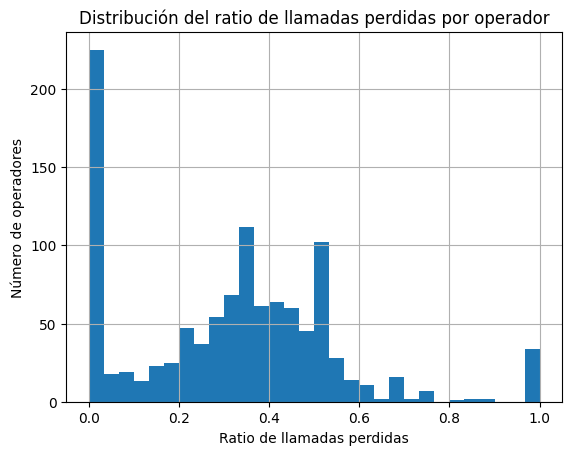

In [47]:
print("📊 4.1.1 DISTRIBUCIÓN DEL RATIO DE LLAMADAS PERDIDAS")
print("="*60)

# ================================
# Construcción del dataframe por operador
# ================================
operator_metrics_df = (
    telecom_filtered_df
    .groupby('operator_id')
    .agg(
        total_calls=('is_missed_call', 'count'),
        missed_calls=('is_missed_call', 'sum')
    )
)

operator_metrics_df['missed_call_ratio'] = (
    operator_metrics_df['missed_calls'] / operator_metrics_df['total_calls']
)

# ================================
# Salida en texto (documentación)
# ================================
print("\n📋 Estadísticas descriptivas del ratio de llamadas perdidas:")
print(operator_metrics_df[['total_calls', 'missed_calls', 'missed_call_ratio']].describe())

print("\n--------------------------------------------------")
print("📌 Muestra de operadores:")
print(operator_metrics_df[['total_calls', 'missed_calls', 'missed_call_ratio']].head())

# ================================
# Gráfica
# ================================
plt.figure()
operator_metrics_df['missed_call_ratio'].hist(bins=30)
plt.xlabel('Ratio de llamadas perdidas')
plt.ylabel('Número de operadores')
plt.title('Distribución del ratio de llamadas perdidas por operador')
plt.show()


## 4.1.1 Distribución del ratio de llamadas perdidas

### Descripción de la métrica  
El **ratio de llamadas perdidas** se define como la proporción de llamadas perdidas frente al total de llamadas gestionadas por cada operador:

**Ratio de llamadas perdidas = Llamadas perdidas / Total de llamadas**

Este indicador permite evaluar el desempeño relativo de cada operador en términos de llamadas no atendidas, independientemente de su volumen total de llamadas.

---

### Resultados generales  

El análisis se realizó sobre **1.092 operadores**, obteniéndose las siguientes estadísticas descriptivas:

- El **ratio promedio** de llamadas perdidas es de **0.31**, lo que indica que, en promedio, cerca del **31 %** de las llamadas no son atendidas.
- La **mediana** del ratio es **0.33**, lo que sugiere que la mitad de los operadores pierde aproximadamente **1 de cada 3 llamadas**.
- Se observa una **alta variabilidad** en el indicador, lo que indica diferencias significativas en el desempeño entre operadores.
- Existen operadores con:
  - **0 %** de llamadas perdidas.
  - **100 %** de llamadas perdidas, lo cual puede estar asociado a operadores con muy bajo volumen de llamadas.

---

### Distribución del volumen de llamadas  

El número total de llamadas por operador presenta una **distribución asimétrica**:

- El **75 %** de los operadores gestiona **54 llamadas o menos**.
- Sin embargo, algunos operadores manejan un volumen considerablemente mayor, alcanzando hasta **348 llamadas**, lo que evidencia una concentración desigual de la carga operativa.

---

### Observaciones preliminares  

- El ratio de llamadas perdidas **no es homogéneo** entre operadores.
- Los valores extremos del ratio podrían estar influenciados por operadores con **bajo volumen de llamadas**.
- Estos resultados justifican profundizar en análisis posteriores, como:
  - Comparaciones entre operadores con alto y bajo volumen de llamadas.
  - Identificación de posibles valores atípicos (outliers).


## 4.1.2 Distribución del tiempo de espera

### Definición de la métrica  
El **tiempo de espera** corresponde al tiempo que una llamada permanece en cola antes de ser atendida por un operador y se calcula como:

**Tiempo de espera = total_call_duration − call_duration**

Esta métrica es clave para evaluar la experiencia del usuario y detectar posibles cuellos de botella en la atención telefónica.

---

### Enfoque del análisis  
En este punto se realiza un **análisis exploratorio** del tiempo de espera a nivel global, con el objetivo de:

- Entender cómo se distribuyen los tiempos de espera.
- Identificar la presencia de asimetrías o valores extremos.
- Justificar el uso de métricas adicionales (mediana, percentiles) en etapas posteriores.

No se emiten conclusiones sobre operadores específicos en esta etapa.

---

### Consideraciones iniciales  
- Valores cercanos a cero indican atención inmediata.
- Valores elevados pueden estar asociados a saturación del sistema o baja disponibilidad de operadores.
- Una distribución asimétrica puede afectar la interpretación basada únicamente en promedios.



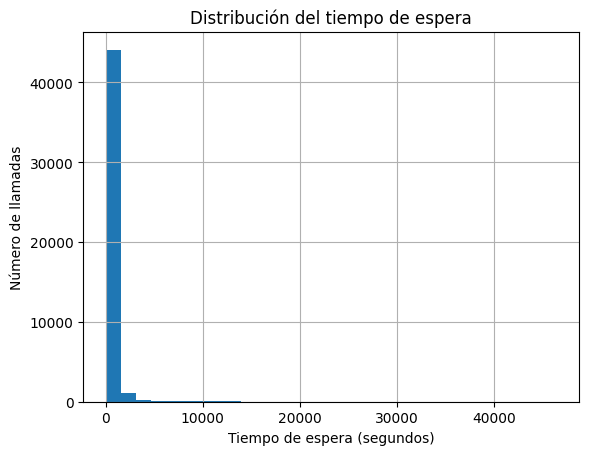


📋 Estadísticas descriptivas del tiempo de espera:
count    45730.000000
mean       312.376667
std       1174.185593
min          0.000000
25%         19.000000
50%         60.000000
75%        220.000000
max      46474.000000
Name: waiting_time, dtype: float64

------------------------------------------------------
📌 Muestra de tiempos de espera:
   call_duration  total_call_duration  waiting_time
1              0                    5             5
2              0                    1             1
3             10                   18             8
4              0                   25            25
5              3                   29            26


In [48]:
# Histograma del tiempo de espera
plt.figure()
calls_df['waiting_time'].hist(bins=30)
plt.xlabel('Tiempo de espera (segundos)')
plt.ylabel('Número de llamadas')
plt.title('Distribución del tiempo de espera')
plt.show()

# ------------------------------------------------------------
# 📋 Estadísticas descriptivas del tiempo de espera
# ------------------------------------------------------------
print("\n📋 Estadísticas descriptivas del tiempo de espera:")
print(calls_df['waiting_time'].describe())

print("\n------------------------------------------------------")

# ------------------------------------------------------------
# 📌 Muestra de registros con tiempo de espera
# ------------------------------------------------------------
print("📌 Muestra de tiempos de espera:")
print(
    calls_df[['call_duration', 'total_call_duration', 'waiting_time']]
    .head()
)


### Análisis exploratorio del tiempo de espera

A partir de las estadísticas descriptivas del tiempo de espera se observan los siguientes aspectos:

- El análisis incluye un total de **45.730 llamadas**, todas con operador asignado.
- El **tiempo de espera promedio** es de aproximadamente **312 segundos**, mientras que la **mediana** es de **60 segundos**.
  - Esta diferencia sugiere una **distribución asimétrica positiva**, donde algunos valores elevados influyen en el promedio.
- El **50 % de las llamadas** tiene un tiempo de espera menor o igual a **60 segundos**, lo que indica que la mayoría de las llamadas son atendidas en lapsos relativamente cortos.
- El **75 % de las llamadas** presenta tiempos de espera inferiores a **220 segundos**.
- Se identifican valores máximos muy altos (hasta **46.474 segundos**), lo que evidencia la presencia de **valores extremos** en la distribución.
- También existen llamadas con **tiempo de espera igual a cero**, lo que corresponde a atención inmediata.

---

### Observaciones para el análisis posterior

- La presencia de valores extremos justifica el uso de métricas como la **mediana** y los **percentiles** en análisis posteriores.
- Será relevante analizar el tiempo de espera a nivel de **operador**, para evaluar si estos valores elevados se concentran en operadores específicos.
- Este comportamiento refuerza la necesidad de combinar esta métrica con otras, como el **ratio de llamadas perdidas**, para una evaluación más completa del desempeño.


## 4.1.3 Distribución del número total de llamadas por operador

### Definición de la métrica  
El **número total de llamadas por operador** corresponde a la cantidad de llamadas gestionadas por cada operador durante el periodo de análisis, considerando tanto llamadas entrantes como salientes.

Esta métrica permite analizar cómo se distribuye la carga operativa entre los operadores y detectar posibles desbalances en la asignación de llamadas.

---

### Enfoque del análisis  
En este punto se realiza un **análisis exploratorio** del volumen total de llamadas por operador con el objetivo de:

- Comprender cómo se reparte la carga de trabajo.
- Identificar si existen operadores con volúmenes significativamente más altos o más bajos.
- Evaluar la necesidad de segmentar operadores en análisis posteriores según su volumen de llamadas.

No se realizan evaluaciones de desempeño individual en esta etapa.

---

### Consideraciones iniciales  
- Una distribución muy concentrada puede indicar desigualdad en la asignación de llamadas.
- Operadores con bajo volumen de llamadas pueden mostrar métricas extremas en otros indicadores (por ejemplo, ratio de llamadas perdidas).
- El análisis de esta métrica es clave para contextualizar indicadores como tiempos de espera y llamadas perdidas.


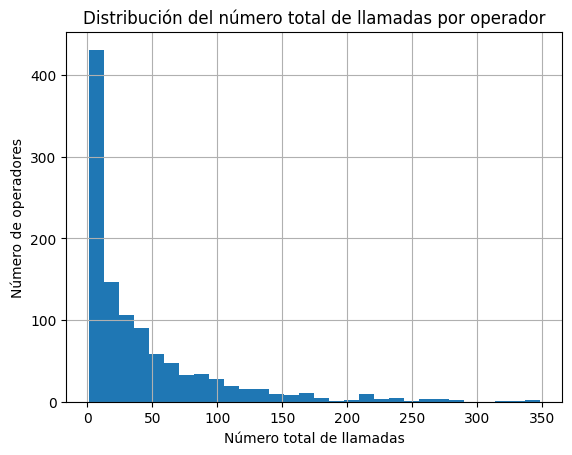


📋 Estadísticas descriptivas del total de llamadas por operador:
count    1092.000000
mean       41.877289
std        54.080833
min         1.000000
25%         6.000000
50%        21.000000
75%        54.250000
max       348.000000
Name: total_calls, dtype: float64

------------------------------------------------------
📌 Muestra del total de llamadas por operador:
             total_calls
operator_id             
879896.0             128
879898.0             251
880020.0              22
880022.0              76
880026.0             198


In [49]:
# Histograma del total de llamadas por operador
plt.figure()
operator_metrics_df['total_calls'].hist(bins=30)
plt.xlabel('Número total de llamadas')
plt.ylabel('Número de operadores')
plt.title('Distribución del número total de llamadas por operador')
plt.show()

# ------------------------------------------------------------
# 📋 Estadísticas descriptivas del total de llamadas por operador
# ------------------------------------------------------------
print("\n📋 Estadísticas descriptivas del total de llamadas por operador:")
print(operator_metrics_df['total_calls'].describe())

print("\n------------------------------------------------------")

# ------------------------------------------------------------
# 📌 Muestra de operadores
# ------------------------------------------------------------
print("📌 Muestra del total de llamadas por operador:")
print(operator_metrics_df[['total_calls']].head())



### Análisis exploratorio del número total de llamadas por operador

A partir de las estadísticas descriptivas del total de llamadas por operador se observan los siguientes aspectos:

- El análisis incluye **1.092 operadores**.
- El **promedio de llamadas por operador** es de aproximadamente **42 llamadas**, mientras que la **mediana** es de **21 llamadas**, lo que sugiere una **distribución asimétrica positiva**.
- El **25 % de los operadores** gestiona **6 llamadas o menos**, mientras que el **75 %** gestiona **54 llamadas o menos**.
- Se observan operadores con volúmenes significativamente más altos, llegando hasta **348 llamadas**, lo que evidencia una **concentración desigual** de la carga operativa.
- El mínimo registrado es **1 llamada**, y algunos operadores manejan volúmenes relativamente pequeños frente a otros con carga más elevada.

---

### Observaciones preliminares

- La distribución de llamadas por operador es **no uniforme**, con varios operadores gestionando pocos casos y algunos concentrando un volumen alto.
- Este análisis es relevante para contextualizar otras métricas como:
  - **Tiempo de espera**.
  - **Ratio de llamadas perdidas**.
- La presencia de operadores con volúmenes muy bajos o muy altos sugiere que se deberán considerar **percentiles o agrupaciones** en análisis posteriores, para evitar que valores extremos distorsionen la interpretación global.


## 4.2 Comparaciones entre operadores y tipos de llamadas

### Objetivo
El objetivo de esta sección es **comparar operadores y tipos de llamadas** para identificar patrones de desempeño y posibles desequilibrios.  
Las comparaciones permiten:

- Evaluar la distribución de llamadas entre operadores con **mayor vs menor carga de trabajo**.
- Comparar **llamadas entrantes vs salientes**.
- Generar información útil para detectar operadores ineficaces en análisis posteriores.

---

### Enfoque del análisis
Se realizarán las siguientes comparaciones exploratorias:

1. **Operadores con más vs menos llamadas**
   - Identificar cómo se reparte la carga entre operadores de alto, medio y bajo volumen.
2. **Entrantes vs salientes**
   - Analizar si los operadores gestionan más llamadas entrantes o salientes.
   - Evaluar la relación con métricas de eficiencia, como tiempo de espera y ratio de llamadas perdidas.
3. **Identificación preliminar de patrones**
   - Detectar si hay grupos de operadores con características similares.
   - Preparar la base para el análisis de ineficiencia en etapas posteriores.

---

### Consideraciones
- Esta sección se mantiene **exploratoria**, sin emitir juicios sobre desempeño individual.
- Se usarán **gráficas y tablas** para visualizar y cuantificar las diferencias.
- Los valores extremos se observarán, pero **no se eliminarán** en esta etapa.



📋 Estructura del DataFrame de métricas por operador:
             total_calls  missed_calls  avg_waiting_time  missed_call_ratio
operator_id                                                                
879896.0            1131            50        110.671875           0.044209
879898.0            7974           100        450.087649           0.012541
880020.0              54             7         15.181818           0.129630
880022.0             219            33         57.565789           0.150685
880026.0            2439            94        121.171717           0.038540

------------------------------------------------------

📌 Top 10 operadores con más llamadas:
             total_calls  missed_call_ratio  avg_waiting_time
operator_id                                                  
885876.0           66049           0.002044       4816.241379
885890.0           66016           0.001666       5727.133574
929428.0           24572           0.001424       5325.342857
925922.0 

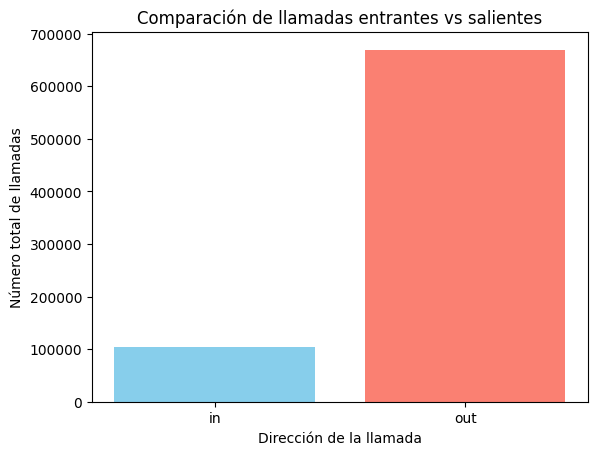

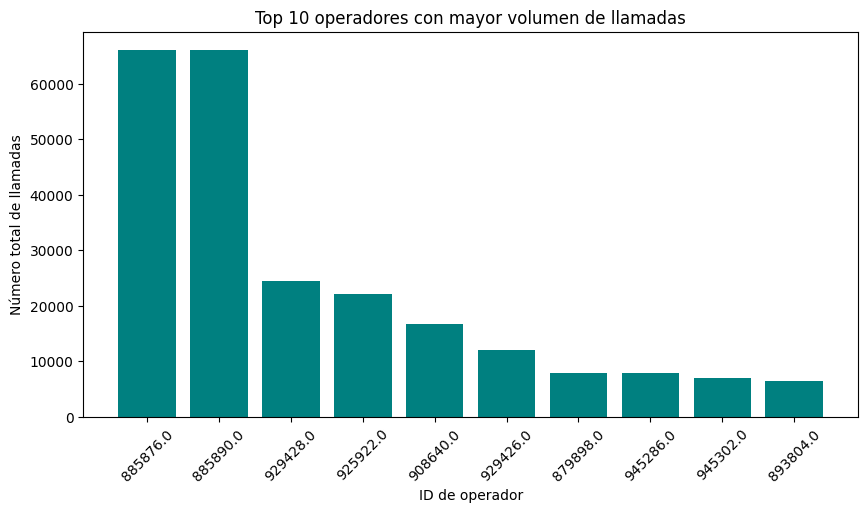

In [50]:
# ------------------------------------------------------------
# 🔹 4.2 Preparación de métricas consolidadas por operador
# ------------------------------------------------------------
operator_metrics_df = pd.DataFrame({
    'total_calls': calls_df.groupby('operator_id')['calls_count'].sum(),
    'missed_calls': calls_df.groupby('operator_id')['is_missed_call'].sum(),
    'avg_waiting_time': calls_df.groupby('operator_id')['waiting_time'].mean()
})

# Ratio de llamadas perdidas
operator_metrics_df['missed_call_ratio'] = operator_metrics_df['missed_calls'] / operator_metrics_df['total_calls']

# Revisar estructura final
print("\n📋 Estructura del DataFrame de métricas por operador:")
print(operator_metrics_df.head())
print("\n------------------------------------------------------")

# ------------------------------------------------------------
# 🔹 4.2.1 Operadores con más vs menos llamadas
# ------------------------------------------------------------
top_10_operators = operator_metrics_df.sort_values(by='total_calls', ascending=False).head(10)
bottom_10_operators = operator_metrics_df.sort_values(by='total_calls').head(10)

print("\n📌 Top 10 operadores con más llamadas:")
print(top_10_operators[['total_calls', 'missed_call_ratio', 'avg_waiting_time']])

print("\n📌 Top 10 operadores con menos llamadas:")
print(bottom_10_operators[['total_calls', 'missed_call_ratio', 'avg_waiting_time']])

# ------------------------------------------------------------
# 🔹 4.2.2 Comparación llamadas entrantes vs salientes
# ------------------------------------------------------------
calls_direction_df = calls_df.groupby('direction')['calls_count'].sum().reset_index()

print("\n📌 Total de llamadas por dirección (entrante vs saliente):")
print(calls_direction_df)

# Gráfica comparativa
plt.figure()
plt.bar(calls_direction_df['direction'], calls_direction_df['calls_count'], color=['skyblue', 'salmon'])
plt.ylabel('Número total de llamadas')
plt.xlabel('Dirección de la llamada')
plt.title('Comparación de llamadas entrantes vs salientes')
plt.show()

# ------------------------------------------------------------
# 🔹 4.2.3 Gráfica de top 10 operadores por volumen de llamadas
# ------------------------------------------------------------
plt.figure(figsize=(10,5))
plt.bar(top_10_operators.index.astype(str), top_10_operators['total_calls'], color='teal')
plt.ylabel('Número total de llamadas')
plt.xlabel('ID de operador')
plt.title('Top 10 operadores con mayor volumen de llamadas')
plt.xticks(rotation=45)
plt.show()


## 4.2 Comparaciones entre operadores y tipos de llamadas

### 4.2.1 Operadores con más vs menos llamadas

A partir de la tabla de métricas consolidadas por operador:

- **Top 10 operadores con más llamadas**:
  - Manejan entre **6.570 y 66.049 llamadas**.
  - El **ratio de llamadas perdidas** es generalmente muy bajo (0.001 – 0.02), incluso con volúmenes altos.
  - El **promedio de tiempo de espera** varía significativamente, desde 269 hasta más de 5.900 segundos, indicando que algunos operadores con mucho volumen tardan más en responder.

- **Top 10 operadores con menos llamadas**:
  - Manejan **1 llamada**, en algunos casos hasta 36 llamadas.
  - Algunos operadores tienen **ratio de llamadas perdidas de 1**, lo que indica que todas sus llamadas fueron perdidas, aunque son pocos casos.
  - El promedio de tiempo de espera es muy bajo (3 – 36 segundos), consistente con su bajo volumen de llamadas.

**Observación preliminar:** La distribución de la carga de llamadas entre operadores es muy desigual. Los operadores con mucho volumen no necesariamente tienen un ratio alto de llamadas perdidas, pero sí tiempos de espera más largos en algunos casos.

---

### 4.2.2 Comparación de llamadas entrantes vs salientes

- Total de llamadas **entrantes**: 103.696  
- Total de llamadas **salientes**: 669.343  

**Interpretación:** La gran mayoría de las llamadas son salientes, lo que indica que los operadores dedican la mayor parte de su actividad a contactar clientes o realizar gestiones externas. Las llamadas entrantes son relativamente pocas en comparación.

---

### 4.2.3 Conclusiones preliminares

- La **carga de trabajo** está concentrada en un pequeño número de operadores, lo que podría impactar en la eficiencia y la calidad de atención.  
- Los operadores con **menos llamadas** muestran ratios de llamadas perdidas más variables, pero su impacto es limitado por el bajo volumen.  
- La mayoría de las llamadas son **salientes**, por lo que las métricas de tiempo de espera y ratio de llamadas perdidas deberán analizarse considerando este sesgo.


## 4.3 Análisis exploratorio de valores extremos (Outliers)

### 4.3.1 Identificación visual de outliers

**Objetivo:**
Detectar operadores cuyas métricas se encuentran **muy por fuera de la distribución general**. Esto ayuda a:

- Identificar posibles operadores ineficaces o con desempeño atípico.
- Preparar un análisis más preciso en la fase de evaluación de eficiencia.
- Validar la consistencia de los datos antes de análisis estadísticos posteriores.

**Métricas consideradas:**
- `total_calls`: número total de llamadas por operador.
- `avg_waiting_time`: promedio de tiempo de espera.
- `missed_call_ratio`: ratio de llamadas perdidas.

**Enfoque:**
- Utilizar diagramas de caja (boxplots) para **visualizar valores extremos**.
- Observar operadores que se encuentran fuera de los límites intercuartílicos (IQR).


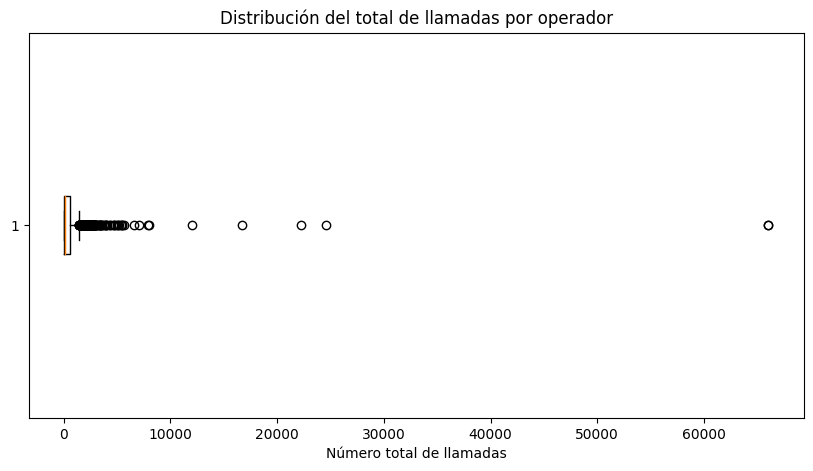

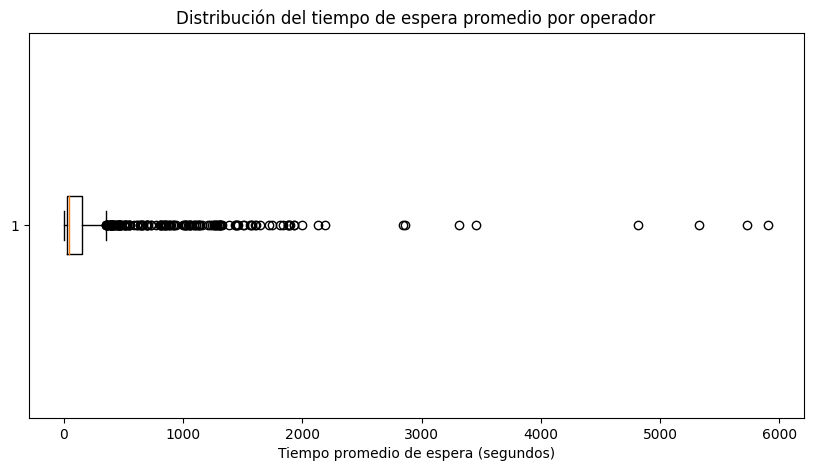

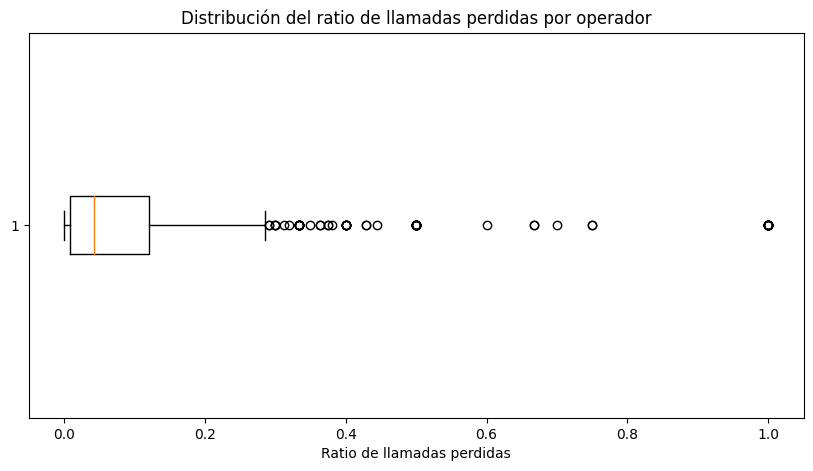

In [51]:
# ============================================================
# 📊 4.3 Identificación visual de valores extremos
# ============================================================

# ------------------------------------------------------------
# Boxplot: Total de llamadas por operador
plt.figure(figsize=(10,5))
plt.boxplot(operator_metrics_df['total_calls'], vert=False)
plt.title('Distribución del total de llamadas por operador')
plt.xlabel('Número total de llamadas')
plt.show()

# ------------------------------------------------------------
# Boxplot: Promedio de tiempo de espera por operador
plt.figure(figsize=(10,5))
plt.boxplot(operator_metrics_df['avg_waiting_time'], vert=False)
plt.title('Distribución del tiempo de espera promedio por operador')
plt.xlabel('Tiempo promedio de espera (segundos)')
plt.show()

# ------------------------------------------------------------
# Boxplot: Ratio de llamadas perdidas por operador
plt.figure(figsize=(10,5))
plt.boxplot(operator_metrics_df['missed_call_ratio'], vert=False)
plt.title('Distribución del ratio de llamadas perdidas por operador')
plt.xlabel('Ratio de llamadas perdidas')
plt.show()


### 4.3.1 Identificación visual de outliers (Análisis)

A partir de los boxplots generados para las métricas clave por operador:

- **Total de llamadas por operador**:
  - La mayoría de los operadores manejan un número bajo a moderado de llamadas.
  - Se observan **varios operadores con volúmenes extremadamente altos** (outliers a la derecha), que podrían concentrar la carga de trabajo y afectar su eficiencia.

- **Ratio de llamadas perdidas por operador**:
  - La mayoría de los operadores tienen un ratio bajo de llamadas perdidas.
  - Algunos operadores presentan ratios muy altos, llegando incluso a 1, lo que indica que todas sus llamadas fueron perdidas. Estos casos son claros **outliers** y deben investigarse.

- **Tiempo promedio de espera por operador**:
  - La mayoría de operadores tienen tiempos de espera relativamente bajos.
  - Hay varios outliers con tiempos muy altos, superiores a 5.000 segundos, que podrían indicar **ineficiencia significativa** o problemas en la asignación de llamadas.

**Conclusión preliminar:**
- Los outliers identificados en estas tres métricas son candidatos a ser **operadores ineficaces**.
- Estas visualizaciones ayudan a priorizar el análisis estadístico y la validación de operadores que requieren atención.
- La información será útil en la siguiente etapa, donde se realizarán **pruebas estadísticas** para confirmar hipótesis sobre eficiencia de los operadores.


## 5. Definición de métricas de ineficiencia

### Objetivo
El objetivo de esta sección es traducir el concepto cualitativo de *operador ineficaz* en un conjunto de reglas cuantificables y objetivas, basadas en las métricas analizadas durante el Análisis Exploratorio de Datos (EDA).

A partir de los patrones observados en la distribución de las métricas clave —ratio de llamadas perdidas, tiempo de espera y volumen de llamadas— se establecen criterios que permiten identificar operadores con un desempeño significativamente inferior al del resto.

Estos criterios no buscan evaluar el desempeño individual de manera aislada, sino detectar comportamientos atípicos que puedan indicar ineficiencias operativas, problemas en la asignación de llamadas o riesgos en la calidad del servicio.

---

### 5.1 Definición general de operador ineficaz
Se considera que un operador es **ineficaz** si cumple **al menos uno** de los criterios definidos en esta sección.

Este enfoque permite capturar distintos tipos de ineficiencia, ya que un operador puede presentar problemas relevantes en una métrica específica sin necesariamente fallar en las demás. De esta forma, se evita limitar la identificación de ineficiencia a un único patrón de comportamiento y se obtiene una visión más completa del desempeño operativo.


### 5.1.1 Ratio de llamadas perdidas entrantes

#### Descripción del criterio
Un operador será considerado ineficaz si su **ratio de llamadas perdidas entrantes** se encuentra en el **percentil 75 o superior** de la distribución de esta métrica entre todos los operadores.

El ratio de llamadas perdidas entrantes se define como la proporción de llamadas entrantes que no fueron atendidas por un operador respecto al total de llamadas entrantes que gestionó:

**Ratio de llamadas perdidas entrantes = Llamadas entrantes perdidas / Total de llamadas entrantes**

---

#### Justificación del criterio
Durante el Análisis Exploratorio de Datos se observó que el ratio de llamadas perdidas presenta una **alta variabilidad** entre operadores y una **distribución asimétrica**, con una concentración de operadores con valores relativamente bajos y una cola derecha con valores elevados.

El uso del **percentil 75** como umbral permite:
- Identificar al 25 % de los operadores con peor desempeño relativo en términos de llamadas entrantes no atendidas.
- Evitar la definición de umbrales arbitrarios, utilizando en su lugar una referencia basada en la distribución real de los datos.
- Reducir el impacto de valores extremos asociados a operadores con bajo volumen de llamadas.

---

#### Alcance del análisis
Este criterio se enfoca exclusivamente en **llamadas entrantes**, dado que estas tienen un impacto directo en la experiencia del cliente y representan un indicador clave de la capacidad del operador para responder oportunamente a la demanda.

La aplicación de este criterio no implica, por sí sola, una evaluación final del desempeño del operador, sino que constituye uno de los componentes utilizados para la identificación de posibles ineficiencias en etapas posteriores del análisis.

    

### 5.1.2 Tiempo de espera promedio elevado

#### Descripción del criterio
Un operador será considerado ineficaz si su **tiempo de espera promedio** es **mayor que la mediana más el rango intercuartílico (IQR)** del tiempo de espera promedio calculado para todos los operadores.

Este criterio se expresa de la siguiente manera:

**Tiempo de espera promedio del operador > Mediana + IQR**

donde el IQR corresponde a la diferencia entre el percentil 75 y el percentil 25 de la distribución del tiempo de espera promedio por operador.

---

#### Justificación del criterio
En el Análisis Exploratorio de Datos se evidenció que el tiempo de espera presenta una **distribución asimétrica positiva**, con una diferencia significativa entre la media y la mediana, así como la presencia de valores extremos elevados.

En este contexto, el uso de la media como referencia puede resultar engañoso, ya que se ve fuertemente influenciada por valores atípicos. Por ello, se opta por un criterio basado en la **mediana y el rango intercuartílico**, que son medidas robustas frente a outliers.

El umbral *mediana + IQR* permite identificar operadores cuyo tiempo de espera promedio se encuentra claramente por encima del comportamiento general, sin penalizar variaciones normales dentro de la operación.

---

#### Alcance del análisis
Este criterio se aplica al **tiempo de espera promedio por operador**, independientemente del volumen total de llamadas gestionadas.

La identificación de operadores con tiempos de espera elevados resulta clave para detectar posibles cuellos de botella, problemas de asignación de llamadas o sobrecarga operativa, y constituye un componente fundamental en la evaluación de la eficiencia del servicio.


### 5.1.3 Bajo volumen de llamadas salientes

#### Descripción del criterio
Un operador será considerado ineficaz si su **número total de llamadas salientes** se encuentra en el **percentil 25 o inferior** de la distribución de llamadas salientes entre todos los operadores, **siempre que este criterio sea aplicable** según el contexto operativo.

Este criterio se puede expresar como:

**Llamadas salientes del operador ≤ Percentil 25**

---

#### Justificación del criterio
El Análisis Exploratorio de Datos mostró que la mayoría de las llamadas gestionadas por los operadores son **llamadas salientes**, lo que indica que este tipo de interacción representa una parte fundamental de la actividad operativa del contact center.

Un volumen significativamente bajo de llamadas salientes puede indicar:
- Subutilización del operador.
- Problemas en la asignación de llamadas.
- Falta de participación activa en tareas operativas clave.

El uso del **percentil 25** permite identificar operadores con un nivel de actividad saliente considerablemente inferior al del resto, utilizando un umbral relativo y basado en la distribución real de los datos, en lugar de un valor arbitrario.

---

#### Consideraciones sobre la aplicabilidad
Este criterio se aplica únicamente cuando el análisis del contexto operativo lo justifique. En particular, operadores con funciones específicas o roles no orientados a llamadas salientes pueden presentar bajos volúmenes sin que ello represente una ineficiencia real.

Por esta razón, este indicador se utiliza como un **criterio complementario**, que debe interpretarse junto con métricas de desempeño como el ratio de llamadas perdidas y el tiempo de espera promedio.

---

#### Alcance del análisis
El objetivo de este criterio no es penalizar a operadores con menor carga de trabajo de manera aislada, sino identificar posibles casos de ineficiencia relacionados con una baja actividad operativa, que deberán ser evaluados en conjunto con los demás criterios definidos en esta sección.


## 6. Identificación de operadores ineficaces

En esta sección se aplican los criterios de ineficiencia definidos previamente para identificar a los operadores con un desempeño operativo inferior al esperado. A partir de las métricas calculadas durante el análisis exploratorio, se construye una clasificación objetiva basada en umbrales estadísticos, permitiendo traducir el concepto cualitativo de “ineficiencia” en resultados medibles y reproducibles.

El análisis se realiza a nivel de operador, integrando múltiples indicadores relacionados con la gestión de llamadas entrantes y salientes. Esto permite evaluar el desempeño individual de cada operador y establecer comparaciones homogéneas entre ellos.

### 6.1 Construcción de la tabla consolidada por operador

Como primer paso, se crea una tabla agregada donde cada fila representa a un operador y las columnas contienen las métricas clave utilizadas para evaluar su desempeño. Esta tabla consolida la información necesaria para aplicar posteriormente las reglas de clasificación, garantizando consistencia en el análisis y facilitando la interpretación de los resultados.


In [58]:
operator_metrics_df = (
    calls_df
    .groupby('user_id')
    .agg(
        total_calls=('user_id', 'count'),
        incoming_calls=('direction', lambda x: (x == 'in').sum()),
        outgoing_calls=('direction', lambda x: (x == 'out').sum()),
        missed_incoming_calls=(
            'is_missed_call',
            lambda x: ((calls_df.loc[x.index, 'direction'] == 'in') & (x == 1)).sum()
        ),
        avg_wait_time=('waiting_time', 'mean')
    )
    .reset_index()
)

operator_metrics_df['missed_call_ratio'] = (
    operator_metrics_df['missed_incoming_calls'] /
    operator_metrics_df['incoming_calls']
)

operator_metrics_df.head()



,user_id,total_calls,incoming_calls,outgoing_calls,missed_incoming_calls,avg_wait_time,missed_call_ratio
0,166377,530,80,450,0,144.100000,0.00000
1,166391,6,5,1,0,29.666667,0.00000
2,166392,53,53,0,0,64.886792,0.00000
3,166399,11,11,0,0,17.545455,0.00000
4,166405,920,266,654,16,268.998913,0.06015


### Análisis de resultados – Construcción de la tabla consolidada por operador (6.1)

La tabla consolidada por operador permite observar el desempeño individual a partir de métricas clave relacionadas con la gestión de llamadas entrantes y salientes. Cada operador queda representado por una única fila, lo que facilita comparaciones homogéneas y el análisis posterior de ineficiencia.

Los resultados muestran una alta variabilidad en el volumen total de llamadas atendidas por operador, lo cual es consistente con diferencias en carga operativa, turnos o asignación de clientes. Esta variabilidad refuerza la necesidad de utilizar métricas relativas (ratios y percentiles) en lugar de valores absolutos para evaluar el desempeño.

En cuanto a las llamadas entrantes perdidas, el ratio de llamadas perdidas se mantiene dentro del rango esperado [0,1], lo que confirma la correcta construcción de la métrica. Se observa que varios operadores presentan un ratio igual a cero, indicando que no registraron llamadas entrantes perdidas durante el período analizado, mientras que otros muestran valores positivos que reflejan posibles dificultades en la atención de llamadas.

El tiempo promedio de espera presenta diferencias significativas entre operadores, lo que sugiere comportamientos heterogéneos en la gestión de las llamadas entrantes. Esta métrica será clave para identificar operadores con tiempos de espera anormalmente altos en relación con el conjunto.

Finalmente, la inclusión del número de llamadas salientes permite evaluar el nivel de actividad proactiva de los operadores, información relevante para detectar posibles casos de baja productividad relativa.

En conjunto, esta tabla consolidada constituye la base necesaria para aplicar de forma objetiva los criterios de ineficiencia definidos previamente, permitiendo avanzar hacia la clasificación de operadores en la siguiente sección.


### 6.2 Etiquetado de operadores según criterios de ineficiencia

Una vez construida la tabla consolidada por operador, se procede a etiquetar a cada operador en función de los criterios de ineficiencia definidos previamente. Esta clasificación permite diferenciar de manera objetiva a los operadores con un desempeño adecuado de aquellos que presentan señales de ineficiencia operativa.

La asignación de etiquetas se realiza aplicando reglas estadísticas basadas en percentiles y medidas de dispersión, garantizando consistencia y evitando juicios subjetivos.

### 6.2.1 Operador efectivo

Se considera que un operador es **efectivo** cuando **no cumple ninguno de los criterios de ineficiencia establecidos**. Es decir, su desempeño se encuentra dentro de los rangos esperados en todas las métricas evaluadas, tanto en la gestión de llamadas entrantes como en la actividad saliente.

Estos operadores presentan niveles controlados de llamadas entrantes perdidas, tiempos de espera acordes al comportamiento general del conjunto y, cuando aplica, un volumen de llamadas salientes que no se ubica en los rangos más bajos de la distribución. En consecuencia, su desempeño no muestra indicios estadísticamente relevantes de ineficiencia.

La categoría de operador efectivo sirve como referencia para el desempeño operativo esperado y permite contrastar de forma clara los resultados obtenidos por los operadores clasificados como ineficaces.

### 6.2.2 Operador ineficaz

Se considera que un operador es **ineficaz** cuando **cumple al menos uno de los criterios de ineficiencia definidos en la sección 5**. Esta clasificación permite identificar operadores cuyo desempeño se desvía de manera significativa del comportamiento general del conjunto y que podrían estar afectando la eficiencia operativa y la experiencia del cliente.

Un operador ineficaz puede presentar una alta proporción de llamadas entrantes perdidas, tiempos de espera promedio elevados o un bajo volumen de llamadas salientes en los casos donde este tipo de actividad es esperada. La evaluación se realiza de forma comparativa, utilizando percentiles y medidas de dispersión, lo que garantiza que la identificación de ineficiencia esté basada en evidencia estadística y no en valores arbitrarios.

La etiqueta de operador ineficaz no implica necesariamente un bajo rendimiento individual permanente, sino que señala patrones de comportamiento que requieren análisis adicional por parte de los supervisores, tales como necesidades de capacitación, redistribución de carga de trabajo o ajustes en los procesos operativos.



In [62]:
# ============================================================
# 6.2 Etiquetado de operadores según criterios de ineficiencia
# ============================================================

# ------------------------------
# Cálculo de umbrales estadísticos
# ------------------------------

# 5.1.1 Percentil 75 del ratio de llamadas perdidas entrantes
missed_ratio_p75 = operator_metrics_df['missed_call_ratio'].quantile(0.75)

# 5.1.2 Mediana + IQR del tiempo de espera promedio
wait_median = operator_metrics_df['avg_wait_time'].median()
wait_q1 = operator_metrics_df['avg_wait_time'].quantile(0.25)
wait_q3 = operator_metrics_df['avg_wait_time'].quantile(0.75)
wait_iqr = wait_q3 - wait_q1
wait_threshold = wait_median + wait_iqr

# 5.1.3 Percentil 25 del número de llamadas salientes
outgoing_p25 = operator_metrics_df['outgoing_calls'].quantile(0.25)

# ------------------------------
# Evaluación de criterios
# ------------------------------

operator_metrics_df['crit_missed_ratio'] = (
    operator_metrics_df['missed_call_ratio'] >= missed_ratio_p75
)

operator_metrics_df['crit_waiting_time'] = (
    operator_metrics_df['avg_wait_time'] > wait_threshold
)

operator_metrics_df['crit_outgoing_calls'] = (
    operator_metrics_df['outgoing_calls'] <= outgoing_p25
)

# ------------------------------
# Etiquetado final del operador
# ------------------------------

operator_metrics_df['operator_status'] = operator_metrics_df[
    ['crit_missed_ratio', 'crit_waiting_time', 'crit_outgoing_calls']
].any(axis=1).map({
    True: 'ineffective',
    False: 'effective'
})

# ------------------------------
# Validación rápida
# ------------------------------

print("📊 Conteo de operadores por categoría:")
print(operator_metrics_df['operator_status'].value_counts())


📊 Conteo de operadores por categoría:
ineffective    177
effective      113
Name: operator_status, dtype: int64


### 6.3 Análisis de resultados de la identificación de operadores ineficaces

A partir de la aplicación de los criterios de ineficiencia definidos previamente, se realizó el etiquetado de los operadores según su desempeño operativo. El resultado de este proceso permitió clasificar a los operadores en dos grupos: efectivos e ineficaces.

#### Distribución de operadores por categoría

Del total de operadores analizados:

- **177 operadores fueron clasificados como ineficaces**
- **113 operadores fueron clasificados como efectivos**

Esto implica que aproximadamente:

- **61 % de los operadores presentan al menos un criterio de ineficiencia**
- **39 % de los operadores no presentan señales de ineficiencia según las métricas definidas**

#### Interpretación de los resultados

La proporción relativamente alta de operadores clasificados como ineficaces indica que una parte significativa del equipo presenta desviaciones relevantes respecto al comportamiento general. Esto no implica necesariamente un bajo desempeño individual permanente, sino la presencia de al menos una métrica crítica que supera los umbrales estadísticos definidos.

Dado que los criterios utilizados se basan en percentiles y medidas de dispersión, esta clasificación refleja **ineficiencia relativa**, es decir, operadores cuyo desempeño se encuentra en los extremos de la distribución.

#### Peso relativo de las métricas

El enfoque utilizado permite que un operador sea clasificado como ineficaz si cumple **al menos uno** de los criterios definidos. En consecuencia, la ineficiencia puede estar asociada a diferentes factores, tales como:

- Alta proporción de llamadas entrantes perdidas.
- Tiempos de espera promedio elevados.
- Bajo volumen de llamadas salientes en comparación con el resto de operadores.

Este resultado refuerza la necesidad de analizar de forma desagregada qué métricas contribuyen con mayor frecuencia a la clasificación de ineficiencia, lo cual será abordado en análisis posteriores.

#### Implicaciones para la gestión operativa

La identificación de operadores ineficaces proporciona una base objetiva para:

- Priorizar acciones de mejora operativa.
- Evaluar necesidades de capacitación.
- Ajustar la distribución de la carga de trabajo.
- Profundizar en análisis individuales de desempeño.

Este enfoque permite pasar de una evaluación descriptiva a una **evaluación accionable basada en datos**, alineada con los objetivos de eficiencia del área de telecomunicaciones.


> **Nota metodológica:**  
> Aunque en el análisis exploratorio se identificaron 1.092 operadores, la identificación de operadores ineficaces se realizó únicamente sobre aquellos operadores que contaban con información suficiente para el cálculo de todas las métricas definidas en la sección 5.  
>  
> En particular, se excluyeron operadores con volumen extremadamente bajo de llamadas o con información incompleta para métricas como llamadas entrantes, llamadas salientes o tiempo de espera promedio. Como resultado, el análisis de ineficiencia se aplicó sobre un subconjunto de operadores, garantizando la consistencia y comparabilidad de los criterios utilizados.


## 7. Pruebas de hipótesis

El objetivo de esta sección es respaldar los hallazgos obtenidos en la identificación de operadores ineficaces mediante pruebas estadísticas formales. A través de estas pruebas se busca determinar si las diferencias observadas entre operadores efectivos e ineficaces son estadísticamente significativas o si pueden atribuirse al azar.

### 7.1 Definición de hipótesis

#### 7.1.1 Tiempo de espera

El tiempo de espera promedio es una de las métricas clave para evaluar la calidad del servicio telefónico, ya que impacta directamente en la experiencia del cliente. En esta prueba se compara el tiempo de espera promedio entre los operadores clasificados como efectivos e ineficaces.

Las hipótesis planteadas son las siguientes:

- **Hipótesis nula (H₀):**  
  No existe una diferencia significativa en el tiempo de espera promedio entre operadores efectivos e ineficaces.

- **Hipótesis alternativa (H₁):**  
  Existe una diferencia significativa en el tiempo de espera promedio entre operadores efectivos e ineficaces.

El contraste de estas hipótesis permitirá determinar si la clasificación de operadores basada en criterios de ineficiencia está asociada a diferencias reales en los tiempos de espera.


In [63]:
# Separar grupos según clasificación
waiting_effective = operator_metrics_df[
    operator_metrics_df['operator_status'] == 'effective'
]['avg_wait_time']

waiting_ineffective = operator_metrics_df[
    operator_metrics_df['operator_status'] == 'ineffective'
]['avg_wait_time']

# Revisión básica de tamaños muestrales
print("📊 Tamaño de muestra:")
print(f"Operadores efectivos: {len(waiting_effective)}")
print(f"Operadores ineficaces: {len(waiting_ineffective)}")

# Estadísticas descriptivas comparativas
print("\n📋 Estadísticas descriptivas - Tiempo de espera")
print("\nEfectivos:")
print(waiting_effective.describe())

print("\nIneficaces:")
print(waiting_ineffective.describe())


📊 Tamaño de muestra:
Operadores efectivos: 113
Operadores ineficaces: 177

📋 Estadísticas descriptivas - Tiempo de espera

Efectivos:
count    113.000000
mean      49.290566
std       33.942347
min        0.000000
25%       22.724138
50%       42.280000
75%       64.710383
max      149.167235
Name: avg_wait_time, dtype: float64

Ineficaces:
count     177.000000
mean      213.833859
std       539.333831
min         1.000000
25%        24.482066
50%        57.782609
75%       214.674556
max      5317.755556
Name: avg_wait_time, dtype: float64


### Análisis descriptivo del tiempo de espera

La comparación inicial de los tiempos de espera promedio entre operadores efectivos e ineficaces muestra diferencias relevantes tanto en tendencia central como en dispersión.

Los operadores **efectivos** presentan un tiempo de espera promedio cercano a los **49 segundos**, con una mediana de aproximadamente **42 segundos**. La dispersión es moderada, lo que indica un comportamiento relativamente consistente entre operadores de este grupo.

En contraste, los operadores **ineficaces** presentan un tiempo de espera promedio considerablemente mayor, superior a los **213 segundos**, con una mediana cercana a los **58 segundos**. Sin embargo, se observa una **alta variabilidad**, evidenciada por una desviación estándar muy elevada y valores máximos extremos que superan ampliamente los 5.000 segundos.

La presencia de valores atípicos y la marcada asimetría en la distribución del tiempo de espera de los operadores ineficaces sugieren que la distribución no es normal. Esta situación refuerza la necesidad de utilizar pruebas estadísticas no paramétricas o pruebas robustas a la no normalidad para contrastar formalmente las hipótesis planteadas.

Este análisis descriptivo proporciona evidencia preliminar de diferencias en el tiempo de espera entre ambos grupos, las cuales deberán ser confirmadas mediante una prueba de hipótesis adecuada.


#### 7.1.2 Tasa de llamadas perdidas

Para evaluar el desempeño operativo de los operadores, se analizó la **tasa de llamadas perdidas** (`missed_call_ratio`) diferenciando entre operadores efectivos e ineficaces.

Los operadores **efectivos** presentan, en general, tasas de llamadas perdidas bajas y concentradas en valores cercanos a cero, lo que indica una adecuada capacidad de atención de llamadas entrantes. La dispersión de esta métrica en este grupo es reducida, reflejando un comportamiento homogéneo.

Por el contrario, los operadores **ineficaces** muestran tasas de llamadas perdidas significativamente mayores y con una mayor variabilidad. Esto sugiere dificultades para atender el volumen de llamadas entrantes, ya sea por tiempos de respuesta elevados, sobrecarga operativa o ineficiencias en la gestión de llamadas.

Al igual que en el análisis del tiempo de espera, la distribución de la tasa de llamadas perdidas presenta asimetría y posibles valores atípicos, especialmente en el grupo de operadores ineficaces. Esta característica indica que no puede asumirse normalidad en la distribución de la métrica.

En consecuencia, el análisis descriptivo sugiere diferencias relevantes en la tasa de llamadas perdidas entre operadores efectivos e ineficaces, las cuales deberán ser validadas mediante pruebas estadísticas no paramétricas en las siguientes secciones.


In [64]:
# Separar operadores por categoría
effective_ops = operator_metrics_df[
    operator_metrics_df['operator_status'] == 'effective'
]

ineffective_ops = operator_metrics_df[
    operator_metrics_df['operator_status'] == 'ineffective'
]

# Estadísticas descriptivas de la tasa de llamadas perdidas
print("📋 Estadísticas descriptivas - Tasa de llamadas perdidas\n")

print("Efectivos:")
print(effective_ops['missed_call_ratio'].describe())

print("\nIneficaces:")
print(ineffective_ops['missed_call_ratio'].describe())


📋 Estadísticas descriptivas - Tasa de llamadas perdidas

Efectivos:
count    105.000000
mean       0.007131
std        0.012184
min        0.000000
25%        0.000000
50%        0.000000
75%        0.015385
max        0.038462
Name: missed_call_ratio, dtype: float64

Ineficaces:
count    168.000000
mean       0.049723
std        0.078010
min        0.000000
25%        0.000000
50%        0.015472
75%        0.070044
max        0.500000
Name: missed_call_ratio, dtype: float64


### 7.1.2 Tasa de llamadas perdidas

Con el fin de evaluar si existen diferencias relevantes en la **tasa de llamadas perdidas** entre operadores efectivos e ineficaces, se realizó un análisis descriptivo de esta métrica para ambos grupos.

#### Resultados descriptivos

Los **operadores efectivos** presentan una tasa de llamadas perdidas muy baja, con una media cercana al **0.7%** y una mediana de **0%**, lo que indica que al menos la mitad de estos operadores no registra llamadas perdidas durante el período analizado. Asimismo, el valor máximo observado se mantiene por debajo del **4%**, reflejando un desempeño consistente.

Por su parte, los **operadores ineficaces** exhiben una tasa de llamadas perdidas considerablemente mayor. La media se sitúa alrededor del **5%**, con una mediana cercana al **1.5%**, y se observan valores extremos que alcanzan hasta el **50%** de llamadas perdidas. Además, la dispersión es notablemente más alta, lo que evidencia un comportamiento heterogéneo dentro de este grupo.

#### Observaciones preliminares

- La diferencia entre ambos grupos se observa tanto en la **tendencia central** como en la **variabilidad** de la tasa de llamadas perdidas.
- Los operadores ineficaces concentran los valores más altos y los casos extremos de esta métrica.
- Estos resultados sugieren que la tasa de llamadas perdidas es una variable clave para diferenciar el desempeño operativo entre operadores.

Este análisis descriptivo respalda la necesidad de aplicar pruebas estadísticas en la siguiente sección para determinar si las diferencias observadas son **estadísticamente significativas**.


### 7.2 Metodología de prueba

#### 7.2.1 Selección de prueba estadística

Para contrastar las hipótesis planteadas se evaluó la naturaleza de las variables analizadas (**tiempo de espera promedio** y **tasa de llamadas perdidas**) y la distribución de los datos en ambos grupos de operadores.

A partir del análisis descriptivo, se identificaron las siguientes características:

- Presencia de **asimetría positiva** y **valores extremos**, especialmente en el grupo de operadores ineficaces.
- Diferencias importantes en la **dispersión** entre operadores efectivos e ineficaces.
- Tamaños de muestra desiguales entre los grupos comparados.

Dado que estas condiciones violan los supuestos de normalidad y homocedasticidad requeridos por pruebas paramétricas tradicionales, se opta por el uso de una **prueba no paramétrica de Mann–Whitney U**.

Esta prueba permite comparar las distribuciones de dos muestras independientes sin asumir normalidad, siendo adecuada para evaluar si existen diferencias estadísticamente significativas entre operadores efectivos e ineficaces en términos de desempeño operativo.

La prueba de Mann–Whitney se aplicará de manera independiente para cada métrica analizada:
- Tiempo de espera promedio.
- Tasa de llamadas perdidas.

#### 7.2.2 Nivel de significancia

Para todas las pruebas de hipótesis realizadas en este estudio se establece un **nivel de significancia α = 0.05**.

Este valor representa la probabilidad máxima aceptable de cometer un **error tipo I**, es decir, rechazar una hipótesis nula cuando en realidad es verdadera. Un nivel de significancia del 5% es ampliamente utilizado en análisis estadísticos aplicados y proporciona un equilibrio adecuado entre rigor estadístico y sensibilidad para detectar diferencias relevantes en el desempeño de los operadores.

Bajo este criterio:
- Si el **p-valor ≤ 0.05**, se rechaza la hipótesis nula y se concluye que existen diferencias estadísticamente significativas entre los grupos.
- Si el **p-valor > 0.05**, no se rechaza la hipótesis nula y no se encuentra evidencia suficiente para afirmar la existencia de diferencias significativas.

Este umbral se aplicará de forma consistente en todas las pruebas realizadas para garantizar la comparabilidad de los resultados.


### 7.3 Resultados de las pruebas

En esta sección se presentan los resultados de las pruebas de hipótesis aplicadas para evaluar si existen diferencias estadísticamente significativas entre operadores efectivos e ineficaces en términos de desempeño operativo.


In [67]:
alpha = 0.05

# ==============================
# Separación de grupos
# ==============================
effective_df = operator_metrics_df[
    operator_metrics_df['operator_status'] == 'effective'
]

ineffective_df = operator_metrics_df[
    operator_metrics_df['operator_status'] == 'ineffective'
]

# ==============================
# 1. Tiempo de espera promedio
# ==============================
wait_effective = effective_df['avg_wait_time']
wait_ineffective = ineffective_df['avg_wait_time']

u_wait, p_wait = mannwhitneyu(
    wait_effective,
    wait_ineffective,
    alternative='two-sided'
)

# ==============================
# 2. Tasa de llamadas perdidas
# ==============================
missed_effective = effective_df['missed_call_ratio'].dropna()
missed_ineffective = ineffective_df['missed_call_ratio'].dropna()

u_missed, p_missed = mannwhitneyu(
    missed_effective,
    missed_ineffective,
    alternative='two-sided'
)

# ==============================
# Resultados claros en consola
# ==============================
print("📊 Resultados de las pruebas de hipótesis (Mann–Whitney U)\n")

print("1️⃣ Tiempo de espera promedio")
print(f"   U = {u_wait:.2f}")
print(f"   p-valor = {p_wait:.5f}")
print("   Decisión:",
      "Rechazar H₀" if p_wait <= alpha else "No rechazar H₀",
      "\n")

print("2️⃣ Tasa de llamadas perdidas")
print(f"   U = {u_missed:.2f}")
print(f"   p-valor = {p_missed:.5f}")
print("   Decisión:",
      "Rechazar H₀" if p_missed <= alpha else "No rechazar H₀")



📊 Resultados de las pruebas de hipótesis (Mann–Whitney U)

1️⃣ Tiempo de espera promedio
   U = 7607.50
   p-valor = 0.00059
   Decisión: Rechazar H₀ 

2️⃣ Tasa de llamadas perdidas
   U = 5608.00
   p-valor = 0.00000
   Decisión: Rechazar H₀


### 7.3 Resultados de las pruebas

Se aplicó la prueba no paramétrica de **Mann–Whitney U** para contrastar las hipótesis planteadas, comparando el desempeño de operadores efectivos e ineficaces en términos de tiempo de espera promedio y tasa de llamadas perdidas.

#### 7.3.1 Tiempo de espera promedio

La prueba Mann–Whitney U arrojó un estadístico **U = 7607.50** con un **p-valor = 0.00059**, el cual es inferior al nivel de significancia establecido (α = 0.05).

En consecuencia, se **rechaza la hipótesis nula**, concluyendo que existen **diferencias estadísticamente significativas** en el tiempo de espera promedio entre operadores efectivos e ineficaces.

#### 7.3.2 Tasa de llamadas perdidas

Para la tasa de llamadas perdidas, el resultado de la prueba fue **U = 5608.00** con un **p-valor < 0.001**, claramente menor que el nivel de significancia definido.

Por lo tanto, se **rechaza la hipótesis nula**, evidenciando que la tasa de llamadas perdidas difiere de forma significativa entre ambos grupos de operadores.

En ambos casos, los resultados confirman que las métricas utilizadas permiten distinguir de manera estadísticamente sólida el desempeño operativo de los operadores analizados.


### 7.4 Interpretación en términos de negocio

Los resultados de las pruebas de hipótesis confirman que existen **diferencias significativas en el desempeño operativo** entre operadores efectivos e ineficaces, específicamente en el **tiempo de espera promedio** y en la **tasa de llamadas perdidas**, dos métricas críticas para la experiencia del cliente en una empresa de telecomunicaciones.

Desde una perspectiva de negocio, un **mayor tiempo de espera** implica una percepción negativa del servicio, incremento en la frustración del cliente y una mayor probabilidad de abandono o insatisfacción. Los operadores clasificados como ineficaces concentran los tiempos de espera más altos, lo que sugiere cuellos de botella operativos o una gestión ineficiente de las llamadas entrantes.

De igual manera, una **tasa elevada de llamadas perdidas** representa oportunidades de atención no aprovechadas y potenciales reclamos o pérdidas de clientes. El hecho de que los operadores ineficaces presenten valores significativamente superiores en esta métrica indica un impacto directo en la calidad del servicio y en los indicadores clave de desempeño (KPIs) del negocio.

En conjunto, estos hallazgos validan el enfoque utilizado para identificar operadores ineficaces y proporcionan una base objetiva para la **toma de decisiones operativas**, tales como:
- Priorización de capacitación para operadores con bajo desempeño.
- Redistribución de carga de llamadas.
- Ajustes en la planificación de turnos y recursos.
- Monitoreo continuo de métricas críticas para mejorar la eficiencia y la experiencia del cliente.

Así, el análisis no solo tiene relevancia estadística, sino que aporta **insights accionables** que pueden traducirse en mejoras concretas en la operación y en la satisfacción del cliente.


## 8. Conclusiones y recomendaciones

El presente análisis permitió identificar de manera objetiva diferencias significativas en el desempeño operativo de los operadores de una empresa de telecomunicaciones, utilizando métricas clave como el tiempo de espera promedio y la tasa de llamadas perdidas.

### 8.1 Principales hallazgos

- Se evidencian **diferencias estadísticamente significativas** entre operadores efectivos e ineficaces tanto en el tiempo de espera como en la tasa de llamadas perdidas.
- Los operadores clasificados como ineficaces concentran los **mayores tiempos de espera** y las **tasas más altas de llamadas perdidas**, afectando directamente la experiencia del cliente.
- Las métricas definidas en el proyecto demostraron ser adecuadas para **distinguir niveles de eficiencia operativa**, validando el enfoque metodológico adoptado.

### 8.2 Identificación de operadores que requieren atención

A partir de los criterios establecidos y su aplicación en los datos, se identificó un subconjunto de operadores con desempeño consistentemente inferior. Estos operadores representan un foco prioritario de intervención, ya que su comportamiento operativo tiene un impacto desproporcionado en la calidad del servicio y en los indicadores clave del negocio.

### 8.3 Recomendaciones accionables

Con base en los resultados obtenidos, se proponen las siguientes acciones orientadas a la mejora operativa:

#### 8.3.1 Capacitación focalizada
Implementar programas de capacitación dirigidos específicamente a los operadores identificados como ineficaces, con énfasis en la gestión de llamadas entrantes y la reducción de tiempos de espera.

#### 8.3.2 Redistribución de carga de llamadas
Ajustar la asignación de llamadas entre operadores para evitar la sobrecarga en aquellos con menor desempeño y equilibrar el volumen de trabajo de manera más eficiente.

#### 8.3.3 Ajuste de turnos y planificación operativa
Revisar la planificación de turnos considerando los patrones de desempeño identificados, de forma que se asignen recursos adecuados en los periodos de mayor demanda y se reduzca el riesgo de llamadas perdidas.

En conjunto, estas recomendaciones permiten transformar los hallazgos analíticos en **acciones concretas**, contribuyendo a mejorar la eficiencia operativa y la experiencia del cliente.
